# Movie Hit Prediction at NeoStudio Pictures
## A Data Science Project for Informed Greenlight Decisions

---

### Executive Summary

**Business Context**: We are data scientists at **NeoStudio Pictures**, a mid-size production company navigating an increasingly competitive film industry. Every year, executives face the critical decision: which movie projects should we greenlight? With production budgets ranging from tens to hundreds of millions of dollars, making the wrong call can be catastrophic.

**The Challenge**: Before a single frame is shot, can we predict whether a movie will become a box office hit (≥$100M worldwide revenue)?

**Our Solution**: This notebook presents a comprehensive machine learning system that analyzes pre-release movie attributes—budget, genre, cast, director, release timing—to predict box office success. Think of it as **risk triage for film projects**.

---

### Key Questions We'll Answer

1. **Classification**: Can we predict whether a movie will be a box office hit (≥$100M worldwide)?
2. **Regression**: Can we accurately forecast the worldwide box office revenue?
3. **Insights**: What factors most strongly predict success? Budget? Genre? Star power? Release timing?
4. **Business Value**: How can executives use these predictions to make better decisions?

---

### What This Notebook Covers

| Section | Description | Key Deliverables |
|---------|-------------|------------------|
| **Part 1: Data Acquisition** | Load TMDB dataset, handle missing values | Clean movie database |
| **Part 2: Exploratory Analysis** | Understand patterns, visualize distributions | Key insights about hits vs non-hits |
| **Part 3: Feature Engineering** | Create predictive features from raw data | Model-ready dataset |
| **Part 4: Baseline Models** | Simple models to establish performance floor | Logistic regression benchmark |
| **Part 5: Advanced Models** | Random Forest, XGBoost, LightGBM | Production-ready classifier |
| **Part 6: Revenue Prediction** | Regression models for box office forecasting | Revenue prediction system |
| **Part 7: Business Applications** | Threshold tuning, recommendations | Actionable executive dashboard |


### Dataset: TMDB 5000 Movies

- **Source**: [Kaggle - TMDB Movie Metadata](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)
- **Files**:
  - `tmdb_5000_movies.csv` - Budget, revenue, genres, production companies
  - `tmdb_5000_credits.csv` - Cast and crew information
- **Size**: ~5,000 movies spanning multiple decades

---

---

# Part 1: Setup & Data Acquisition

## 1.1 Environment Setup

First, we'll install and import all necessary libraries. This notebook is designed to work seamlessly in Google Colab or any local Jupyter environment.

In [ ]:
# Install required packages (automatically handled in Colab)
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm kaggle

In [ ]:
# Import core libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)
import xgboost as xgb
import lightgbm as lgb

# Configure visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" All packages imported successfully!")
print(f" Pandas version: {pd.__version__}")
print(f" NumPy version: {np.__version__}")
print(f" Scikit-learn is ready")
print(f" XGBoost and LightGBM are ready")

 All packages imported successfully!
 Pandas version: 2.2.2
 NumPy version: 2.0.2
 Scikit-learn is ready
 XGBoost and LightGBM are ready


## 1.2 Dataset Download Options

Get TMDB dataset into this notebook.

1. Download from [Kaggle TMDB Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)
2. Upload the two CSV files when prompted below

## Dataset Overview

We are using the **TMDB 5000 dataset**, a rich archive of film history. To conduct our analysis, we require **two distinct files**:

1. **tmdb_5000_movies.csv**  
   - Contains **business data**: Budgets, Revenue, Release Dates

2. **tmdb_5000_credits.csv**  
   - Contains **creative data**: Cast lists, Director names, Crew roles

These files will be uploaded to our environment to begin the **data extraction and feature engineering process**.


In [ ]:
# Create necessary directories
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

print("📁 Directory structure created:")
print("  - data/raw/ (for input CSV files)")
print("  - data/processed/ (for cleaned dataset)")

# Uncomment ONE of the following sections based on your preferred method:

# OPTION 1: Manual Upload (Recommended for Colab)
# ------------------------------------
from google.colab import files
print("\n📤 Please upload tmdb_5000_movies.csv:")
uploaded1 = files.upload()
print("\n📤 Please upload tmdb_5000_credits.csv:")
uploaded2 = files.upload()
print("\n✓ Files uploaded successfully!")

📁 Directory structure created:
  - data/raw/ (for input CSV files)
  - data/processed/ (for cleaned dataset)

📤 Please upload tmdb_5000_movies.csv:


Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv

📤 Please upload tmdb_5000_credits.csv:


Saving tmdb_5000_credits.csv to tmdb_5000_credits.csv

✓ Files uploaded successfully!


## 1.3 Load and Inspect Data

Now that the files are uploaded, we can **load them into memory** and inspect the raw datasets.

---

### Movies Dataset

- Expected size: ~4,800 rows (movies)  
- Columns: ~20 metadata fields, including budgets, revenue, and release dates

---

### Credits Dataset

- Links to movies via a **unique ID**  
- Contains cast and crew information, allowing us to identify actors, directors, and other key roles

---

### Next Step

- Print the **shape** of both datasets to ensure proper loading  
- Confirm the data is ready for the **cleaning and feature engineering process**


In [ ]:
print("LOADING TMDB MOVIE DATASET")
movies_df = pd.read_csv('tmdb_5000_movies.csv')
credits_df = pd.read_csv('tmdb_5000_credits.csv')
print(" Datasets loaded successfully!\n")

print(f" Movies dataset shape: {movies_df.shape}")
print(f"   - {movies_df.shape[0]:,} movies")
print(f"   - {movies_df.shape[1]} columns\n")

print(f" Credits dataset shape: {credits_df.shape}")
print(f"   - {credits_df.shape[0]:,} records")
print(f"   - {credits_df.shape[1]} columns")

LOADING TMDB MOVIE DATASET
 Datasets loaded successfully!

 Movies dataset shape: (4803, 20)
   - 4,803 movies
   - 20 columns

 Credits dataset shape: (4803, 4)
   - 4,803 records
   - 4 columns


In [ ]:
# Preview the movies dataset
if not movies_df.empty:
    print("MOVIES DATASET - FIRST GLIMPSE")
    display(movies_df.head())
    print("\n Column Overview:")
    print(movies_df.info())

MOVIES DATASET - FIRST GLIMPSE


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124



 Column Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  st

## What We Found

This dataset is a **gold mine**, but it requires significant refinement before it can be used effectively for modeling.

---

## The Target Variable

We observe a `revenue` column in the dataset.  
This will serve as our **North Star**.

By comparing **revenue** against **budget**, we can define precisely what constitutes a **“Hit”** using **Return on Investment (ROI)** rather than raw earnings alone.

---

## The JSON Challenge

Several columns—such as `genres`, `keywords`, and `production_companies`—are stored as **raw JSON strings**, for example:


[{"id": 28, "name": "Action"}]


Machine learning models cannot interpret these structures directly.  
We will need to perform **feature engineering** to unpack these JSON strings into usable binary or categorical features, such as:

- `is_action_movie = 1`
- `has_major_studio = 1`

---

## Missing Data

The `.info()` summary reveals some missing values:

- Columns like `tagline` and `homepage` contain nulls.

Crucially, our **key financial columns** (`budget`, `revenue`) appear mostly intact.  
We will formally verify this data integrity during the **data cleaning phase**.

---

## Strategic Insight

The `budget` variable spans an enormous range—from tiny independent films to massive blockbusters (for example, *Avatar* at approximately \$237M).

This wide variance is essential:

- It allows the model to distinguish between a **“niche hit”** and a **“global blockbuster”**
- It improves the model’s ability to generalize across different scales of film production




In [ ]:
# Preview the credits dataset
if not credits_df.empty:
    print("CREDITS DATASET - FIRST GLIMPSE")
    display(credits_df.head())

    print("\n Column Overview:")
    print(credits_df.info())

CREDITS DATASET - FIRST GLIMPSE


,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."



 Column Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB
None


## What We Found

This dataset holds the **“Creative DNA”** of the films, but much of that value is currently locked inside complex, nested structures.

---

## The Bridge

The `movie_id` column exists in this dataset.  
This is the **critical key** we will use to link the **Cast & Crew data** with the **Financial data** in the next step.

---

## Hidden Value

The `cast` and `crew` columns contain **large, nested lists** of information that are not immediately usable in their raw form.

### Cast
- Embedded within the cast data is a potential **“Star Power”** metric.
- By extracting the **top-billed actors**, we can test whether the presence of specific **A-list actors** correlates with a higher probability of a box-office hit.

### Crew
- The crew data contains information about key contributors, most importantly the **Director**.
- Our hypothesis is that the **Director** is the single most predictive human factor in determining a film’s success.

---

## The Plan

Analyzing these datasets separately limits their effectiveness.  
In **Part 2**, we will **merge these datasets** to create a single **Master Record** for each movie, directly linking **financial performance** to **creative talent**.


---

# Part 2: Data Cleaning & Preparation

## 2.1 Merge Datasets

The movies and credits datasets contain complementary information. We'll merge them to create a unified dataset for analysis.

In [ ]:
if not movies_df.empty and not credits_df.empty:
    print("MERGING DATASETS")

    # Determine merge key
    if 'id' in movies_df.columns and 'movie_id' in credits_df.columns:
        df = movies_df.merge(credits_df, left_on='id', right_on='movie_id', how='inner')
        print(" Merged on: movies.id = credits.movie_id")
    elif 'id' in movies_df.columns and 'id' in credits_df.columns:
        df = movies_df.merge(credits_df, on='id', how='inner')
        print(" Merged on: id (common column)")
    else:
        print("  Warning: Could not find common merge key")
        df = movies_df  # Fallback to movies only

    print(f"\n Merged dataset shape: {df.shape}")
    print(f"   - {df.shape[0]:,} movies")
    print(f"   - {df.shape[1]} total columns")
    print("\n Datasets successfully merged!")

MERGING DATASETS
 Merged on: movies.id = credits.movie_id

 Merged dataset shape: (4803, 24)
   - 4,803 movies
   - 24 total columns

 Datasets successfully merged!


## Data Integration Complete

We have successfully fused the **financial ledger** with the **talent ledger**.

---

## Result

We now have a **single dataframe** containing **24 columns** for every movie.

---

## Why This Matters

This unified dataset allows us to ask questions that span both creative and financial domains, such as:

- Do movies with higher budgets (from the financial data) hire more popular actors (from the cast data)?
- Does a director’s track record have a measurable impact on revenue?

---

## Integrity Check

The row count remained at **4,803**, confirming that every movie in our financial dataset successfully matched with a corresponding entry in the credits dataset.

No data was lost during the merge process.


## 2.2 Initial Data Cleaning

**The Reality of Movie Data**: Not all records are complete or valid. We need to:
- Remove movies with missing or zero budget/revenue (can't predict what we can't measure)
- Handle invalid release dates
- Convert data types appropriately

In [ ]:
if not df.empty:
    print("DATA CLEANING PIPELINE")

    print(f"\n Initial dataset size: {len(df):,} movies")

    # Step 1: Keep only movies with valid budget and revenue
    print("\n[Step 1] Removing movies with missing/zero budget or revenue...")
    df = df[df['budget'].notna() & df['revenue'].notna()]
    df = df[(df['budget'] > 0) & (df['revenue'] > 0)]
    print(f"    {len(df):,} movies remaining")

    # Step 2: Convert release_date to datetime
    print("\n[Step 2] Processing release dates...")
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df = df[df['release_date'].notna()]
    print(f"    {len(df):,} movies with valid release dates")

    # Step 3: Convert numeric columns
    print("\n[Step 3] Converting numeric columns...")
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
    print("    Numeric conversions complete")

    # Step 4: Remove remaining nulls in key columns
    print("\n[Step 4] Final cleanup...")
    df = df.dropna(subset=['budget', 'revenue', 'runtime'])
    print(f"    {len(df):,} movies in final cleaned dataset")
    print(f" DATA CLEANING COMPLETE: {len(df):,} movies ready for analysis")

DATA CLEANING PIPELINE

 Initial dataset size: 4,803 movies

[Step 1] Removing movies with missing/zero budget or revenue...
    3,229 movies remaining

[Step 2] Processing release dates...
    3,229 movies with valid release dates

[Step 3] Converting numeric columns...
    Numeric conversions complete

[Step 4] Final cleanup...
    3,229 movies in final cleaned dataset
 DATA CLEANING COMPLETE: 3,229 movies ready for analysis


## What Just Happened?

You will notice that our dataset size dropped from **4,803** to **3,229** movies.  
This means we discarded approximately **33%** of the raw data.

---

## Is This a Problem?

No — this step is a **necessity**, not a mistake.

The removed records were effectively **“ghost data”**: movies with reported **budgets or revenues of \$0**, most likely due to incomplete reporting for smaller, older, or obscure films.

---

## The Risk

If we trained our model on films with \$0 revenue or \$0 budget, the model could learn a fundamentally incorrect pattern:

> *“Making movies costs nothing and earns nothing.”*

This would severely distort predictions and undermine model credibility.

---

## The Reward

The remaining **3,229 films** represent **complete, high-quality commercial records**.

This **Clean Set**:
- Contains reliable financial information
- Reflects real-world economic outcomes
- Is suitable for building a **professional-grade predictive engine**

---

## Next Step

Now that we have clean and trustworthy numbers, we must define our objective:

**What exactly constitutes a “Hit”?**

---

# Part 3: Defining Success

## 3.1 What Makes a "Hit" Movie?

In the film industry, **"box office hit"** is a somewhat subjective term. For this analysis, we'll use a clear, data-driven definition:

### Hit Definition: Worldwide Revenue ≥ $100 Million

**Why $100M?**
- Industry standard for "blockbuster" status
- Covers production costs and generates profit for most films
- Aligns with Hollywood's internal benchmarks

We'll create two target variables:
1. **Binary Target**: `hit` (1 if revenue ≥ $100M, else 0)
2. **Regression Target**: `log_revenue` (log-transformed revenue for prediction)

In [ ]:
if not df.empty:
    print("DEFINING SUCCESS: THE $100M THRESHOLD")

    # Define worldwide revenue
    df['worldwide_revenue'] = df['revenue']

    # Create binary target: hit = 1 if revenue >= $100M
    HIT_THRESHOLD = 100_000_000  # $100 million
    df['hit'] = (df['worldwide_revenue'] >= HIT_THRESHOLD).astype(int)

    # Create regression target: log revenue (helps with skewed distribution)
    df['log_revenue'] = np.log1p(df['worldwide_revenue'])

    # Calculate statistics
    total_movies = len(df)
    num_hits = df['hit'].sum()
    num_non_hits = total_movies - num_hits
    hit_rate = df['hit'].mean() * 100

    print(f"\n Dataset Statistics:")
    print(f"   Total movies: {total_movies:,}")
    print(f"   Hits (≥$100M): {num_hits:,} ({hit_rate:.1f}%)")
    print(f"   Non-hits (<$100M): {num_non_hits:,} ({100-hit_rate:.1f}%)")
    print(f"\n Insight: About {hit_rate:.0f}% of movies become box office hits!")
    print("   This is our baseline - any model must beat this to be useful.")

DEFINING SUCCESS: THE $100M THRESHOLD

 Dataset Statistics:
   Total movies: 3,229
   Hits (≥$100M): 1,124 (34.8%)
   Non-hits (<$100M): 2,105 (65.2%)

 Insight: About 35% of movies become box office hits!
   This is our baseline - any model must beat this to be useful.


## The Baseline to Beat

**Status:** Target Locked

---

## What We Found

Out of our clean dataset of **3,229 movies**:

- **35% (1,124 movies)** earned **≥ $100M** (*Hits*)
- **65% (2,105 movies)** earned **< $100M** (*Non-Hits*)

---

## The Baseline Logic

If we built a simple baseline model that predicted **Non-Hit** for every movie, it would be correct **65% of the time**.

This establishes our **benchmark accuracy**.

- A machine learning model with **~70% accuracy** would be only marginally useful.
- A model achieving **85% or higher accuracy** would represent a **powerful, business-relevant tool**.

---

## Next Step

We will visualize this class split to confirm that our target variable is not overly imbalanced.  
If significant imbalance exists, we may need to apply specialized modeling or resampling techniques.


##Visualizing the Count

First, let's look at the raw numbers. How many "Hits" do we actually have to work with?

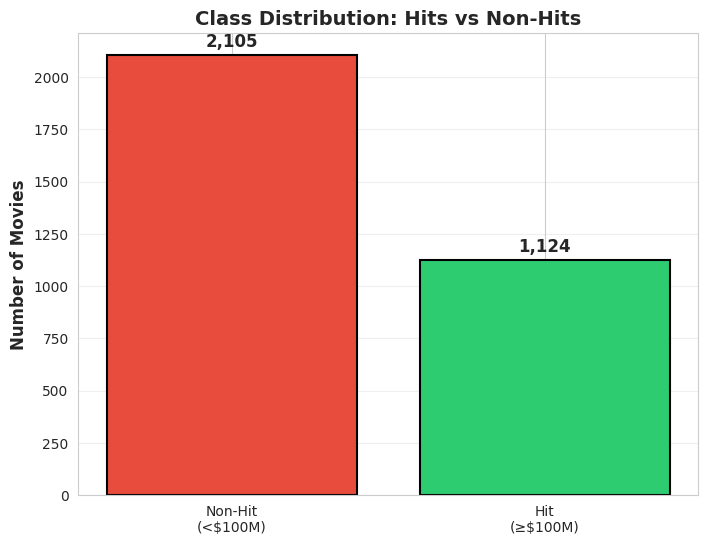

In [ ]:
# 3.2 Class Distribution (Bar Chart)
if not df.empty:
    hit_counts = df['hit'].value_counts()
    colors = ['#e74c3c', '#2ecc71']  # Red for non-hits, green for hits

    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Non-Hit\n(<$100M)', 'Hit\n(≥$100M)'],
            [hit_counts[0], hit_counts[1]],
            color=colors, edgecolor='black', linewidth=1.5)

    plt.ylabel('Number of Movies', fontsize=12, fontweight='bold')
    plt.title('Class Distribution: Hits vs Non-Hits', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 20,
                 f'{int(height):,}',
                 ha='center', va='bottom', fontweight='bold', fontsize=12)
    plt.show()

## Insight 1: The Class Balance

### The Numbers

- **Hits:** 1,124 movies  
- **Non-Hits:** 2,105 movies  

---

### Why This Matters

Although unsuccessful movies outnumber successful ones, the imbalance is **not severe** (approximately a **2:1 ratio**).

This is important because:
- We do **not** need aggressive resampling techniques (e.g., SMOTE)
- Unlike domains such as fraud detection or rare disease diagnosis, we have a sufficient number of positive examples
- The model has enough **Hit** cases to reliably learn the patterns associated with success


## Establishing the Baseline

Next, we convert the class counts into percentages to establish our **accuracy floor**.

This represents the performance of a zero-skill model that always predicts the majority class and serves as the minimum benchmark our machine learning models must exceed.


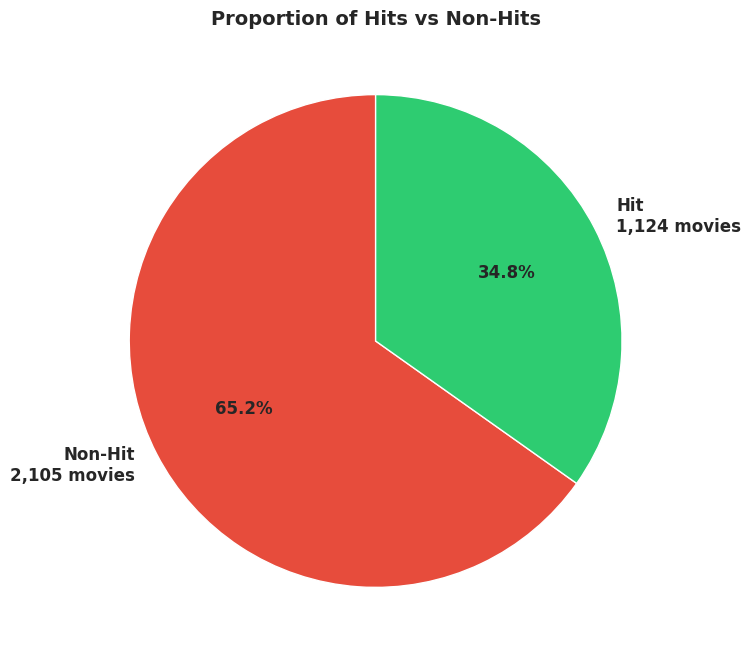

In [ ]:
# 3.3 Class Proportions (Pie Chart)
if not df.empty:
    plt.figure(figsize=(8, 8))
    plt.pie([hit_counts[0], hit_counts[1]],
            labels=[f'Non-Hit\n{hit_counts[0]:,} movies', f'Hit\n{hit_counts[1]:,} movies'],
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})

    plt.title('Proportion of Hits vs Non-Hits', fontsize=14, fontweight='bold')
    plt.show()

## Insight 2: The "Naive" Baseline

### The Stat

- **65.2%** of movies in our dataset fail to reach the **$100M** revenue mark.

---

### The Benchmark

If we built a zero-skill model that always predicted **“Non-Hit”**, it would achieve **65.2% accuracy**.

This establishes our **baseline performance**.

---

### The Goal

- Any machine learning model must **significantly outperform** this baseline  
- **70% accuracy** would be unimpressive  
- **85%+ accuracy** is the target to deliver **meaningful business value**


## The Financial Reality

Finally, we visualize the **actual revenue distribution** to understand the full spread of movie earnings and the economic landscape our model is learning from.


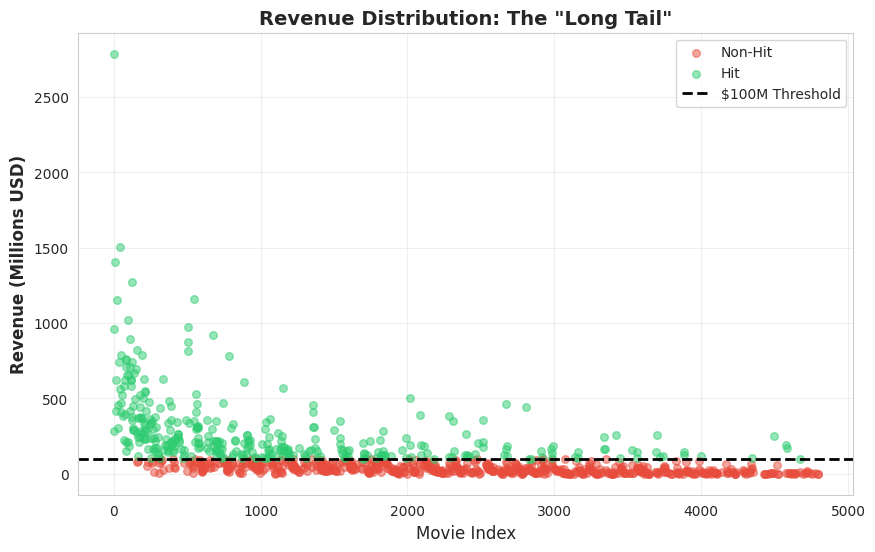


 Target variables successfully defined


In [ ]:
# 3.4 Revenue Distribution (Scatter Plot)
if not df.empty:
    plt.figure(figsize=(10, 6))
    df_sample = df.sample(min(1000, len(df)))  # Sample for cleaner visualization

    # Plot Non-Hits
    plt.scatter(df_sample[df_sample['hit']==0].index,
                df_sample[df_sample['hit']==0]['worldwide_revenue']/1e6,
                alpha=0.5, c='#e74c3c', s=30, label='Non-Hit')

    # Plot Hits
    plt.scatter(df_sample[df_sample['hit']==1].index,
                df_sample[df_sample['hit']==1]['worldwide_revenue']/1e6,
                alpha=0.5, c='#2ecc71', s=30, label='Hit')

    # Add Threshold Line
    plt.axhline(y=100, color='black', linestyle='--', linewidth=2, label='$100M Threshold')

    plt.xlabel('Movie Index', fontsize=12)
    plt.ylabel('Revenue (Millions USD)', fontsize=12, fontweight='bold')
    plt.title('Revenue Distribution: The "Long Tail"', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

    print("\n Target variables successfully defined")

## Insight 3: The "Long Tail" Economy

### The Distribution

This scatter plot exposes the extreme economics of the film industry:
- Most movies cluster near the bottom with **low revenue**
- A small number of **outliers** soar into the billions, dominating total earnings

---

### The "Hit" Zone

- The **black dashed line** marks the **$100M revenue threshold**
- Any movie above this line qualifies as a **Hit** and represents our prediction target

---

### Modeling Implication

The enormous gap between a modest success (e.g., ~$150M) and a mega-hit (e.g., ~$2.7B) reinforces a critical modeling choice:

- We must use a **log transformation** (`log_revenue`) for regression tasks
- Without it, extreme outliers would overwhelm the model
- Log scaling allows the model to learn meaningful patterns across vastly different revenue scales


## Strategic Checkpoint

**Status:** Target Locked

---

### Ground Truth Defined

We have formally defined the objective of this project:

- **Goal:** Predict whether a movie earns **≥ $100M** in revenue  
- **Baseline:** Approximately **35%** of movies achieve this outcome

This establishes the **minimum performance threshold**:
- Any model performing **below 35% accuracy** is worse than random guessing

---

### Next Step

Now that success is clearly defined, the focus shifts to **causality and signal discovery**.

In **Part 4**, we will explore the relationships between **budget**, **runtime**, and **revenue** to uncover the predictive signals that drive movie success.


---

# Part 4: Exploratory Data Analysis

## 4.1 Understanding the Landscape

Before building predictive models, we need to understand our data deeply. What patterns exist? What factors correlate with success?

In [ ]:
if not df.empty:
    # Create log budget for better visualization
    df['log_budget'] = np.log1p(df['budget'])

    print("="*80)
    print("DESCRIPTIVE STATISTICS")
    print("="*80)
    print("\n Summary of Key Numerical Features:\n")
    display(df[['budget', 'revenue', 'runtime', 'log_budget', 'log_revenue']].describe())

DESCRIPTIVE STATISTICS

 Summary of Key Numerical Features:



,budget,revenue,runtime,log_budget,log_revenue
count,3.229000e+03,3.229000e+03,3229.000000,3229.000000,3229.000000
mean,4.065444e+07,1.212430e+08,110.724373,16.799904,17.491159
std,4.439674e+07,1.863029e+08,20.965694,1.661809,2.078763
min,1.000000e+00,5.000000e+00,41.000000,0.693147,1.791759
25%,1.050000e+07,1.700000e+07,96.000000,16.166886,16.648724
50%,2.500000e+07,5.518472e+07,107.000000,17.034386,17.826197
75%,5.500000e+07,1.462920e+08,121.000000,17.822844,18.801115
max,3.800000e+08,2.787965e+09,338.000000,19.755682,21.748578


## The "Average" Movie Profile

**Status:** Vital Signs Checked

---

## What the Numbers Tell Us

### 1. The "Blockbuster Skew"

- **Mean Budget:** $40M  
- **Median Budget:** $25M  

This indicates that a small number of **massive productions** (e.g., *Avengers*) are inflating the average budget.  
The **typical movie** is considerably more modest in scale.

---

### 2. The Revenue Gap

- **Average Revenue:** ~$121M  
- **Median Revenue:** ~$55M  

Again, a few extreme outliers drive the mean much higher than the median.

---

### Implication

This **extreme inequality** in budgets and revenues explains why we rely on **logarithmic scales** in our visualizations:

- Raw dollar plots would be dominated by the mega-hits
- Smaller and moderately successful films would appear flattened, making charts **hard to interpret**
- Log scales compress outliers and reveal meaningful patterns across the full distribution


## The Cost of Doing Business

First, we analyze the **financial input** to filmmaking.

How much does it cost to play the game?


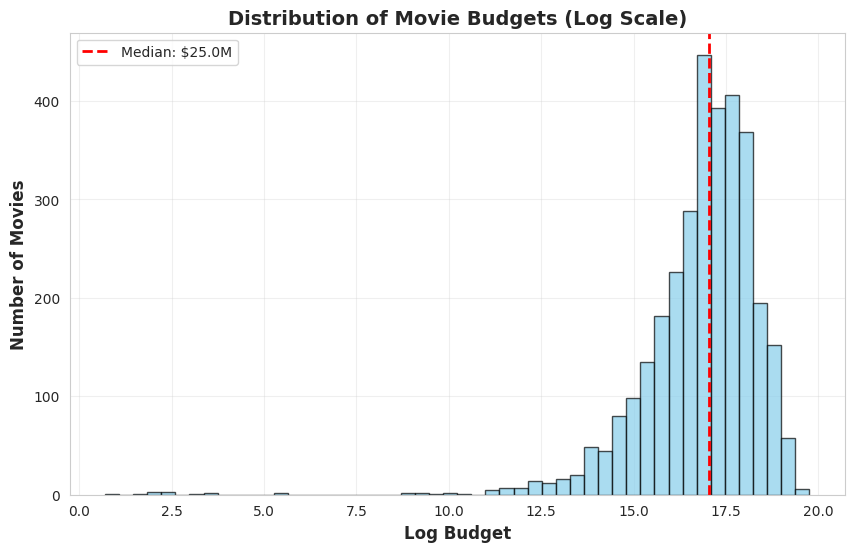

In [ ]:
# 4.2 Distribution of Movie Budgets
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.hist(df['log_budget'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

    plt.xlabel('Log Budget', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Movies', fontsize=12, fontweight='bold')
    plt.title('Distribution of Movie Budgets (Log Scale)', fontsize=14, fontweight='bold')

    # Add median line
    median_val = np.expm1(df["log_budget"].median()) / 1e6
    plt.axvline(df['log_budget'].median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: ${median_val:.1f}M')

    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## Insight 1: The "Blockbuster Skew"

### The Shape

The budget distribution closely follows a **bell curve (normal distribution)**, indicating that movie financing is relatively standardized across the industry.

---

### The Reality

- The **median production budget** is approximately **$25 million**
- This represents the cost of a *typical* movie, not the highly publicized extremes

---

### The Outliers

- Ultra-high-budget films (e.g., $200M Marvel productions) sit on the far right tail
- These are **statistical anomalies**, not the norm

**Modeling Implication:**  
Our model must be robust enough to handle both:
- The common **$25M-scale films**
- The rare but influential **$200M+ tentpole productions**


## The Mountain to Climb

Next, we examine the **target variable: Revenue**.

This chart visually highlights the **challenge of predicting movie success**, showing the distribution and extreme variability of earnings across the industry.


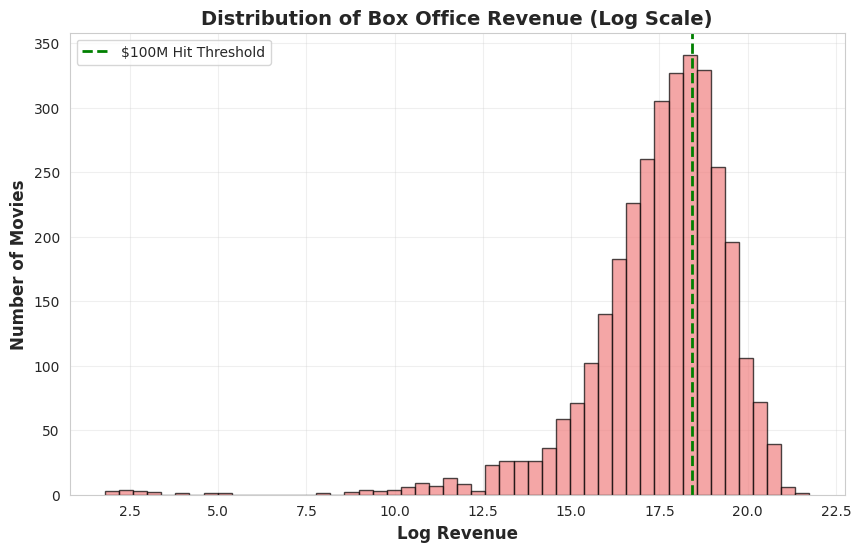

In [ ]:
# 4.3 Distribution of Revenue
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.hist(df['log_revenue'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)

    plt.xlabel('Log Revenue', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Movies', fontsize=12, fontweight='bold')
    plt.title('Distribution of Box Office Revenue (Log Scale)', fontsize=14, fontweight='bold')

    # Add Threshold Line
    plt.axvline(np.log1p(100_000_000), color='green', linestyle='--', linewidth=2,
                label='$100M Hit Threshold')

    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## Insight 2: Visualizing the "Hit" Zone

### The Threshold

- The **green dashed line** marks our **$100M success threshold**

---

### The Challenge

- Most movies (red bars) fall **below the green line**  
- Achieving $100M revenue is statistically rare

---

### Business Implication

- Hitting $100M is an **elite achievement**  
- The default outcome is **failure to reach this mark**  
- Our model must predict which movies can **successfully cross this chasm**


## The ROI Relationship (Crucial)

This is the most important chart in the EDA, illustrating the relationship between **Money In (Budget)** and **Money Out (Revenue)**.

It helps us understand the financial dynamics of movie production and identifies which investments are likely to yield a hit.


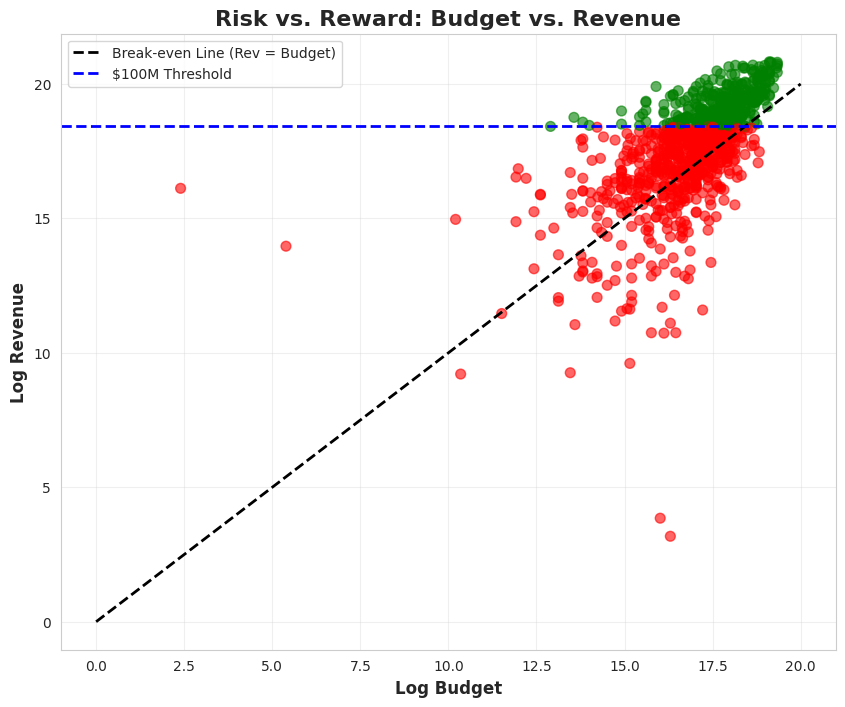

In [ ]:
# 4.4 Budget vs Revenue Scatter Plot
if not df.empty:
    plt.figure(figsize=(10, 8))

    # Sample data to avoid overcrowding the plot
    sample_data = df.sample(min(1000, len(df)))
    colors = ['red' if x == 0 else 'green' for x in sample_data['hit']]

    plt.scatter(sample_data['log_budget'], sample_data['log_revenue'],
                c=colors, alpha=0.6, s=50)

    # Add reference lines
    plt.plot([0, 20], [0, 20], 'k--', linewidth=2, label='Break-even Line (Rev = Budget)')
    plt.axhline(np.log1p(100_000_000), color='blue', linestyle='--', linewidth=2, label='$100M Threshold')

    plt.xlabel('Log Budget', fontsize=12, fontweight='bold')
    plt.ylabel('Log Revenue', fontsize=12, fontweight='bold')
    plt.title('Risk vs. Reward: Budget vs. Revenue', fontsize=16, fontweight='bold')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    plt.show()

## Insight 3: The Risk Landscape

### The Trend

- Clear **positive correlation** between budget and revenue  
- Higher spending generally **increases potential revenue ceiling**

---

### The "Danger Zone"

- **Red dots below the black diagonal line** represent movies that **spent heavily but earned little**  
- These are the **expensive failures** that studios want to avoid

---

### The Goal

- The model’s primary value is to **predict these high-risk investments**  
- By identifying likely failures **before production**, studios can make informed greenlighting decisions


## The Industry Standard

Finally, we examine **movie runtime** to assess whether film length has any impact on success.


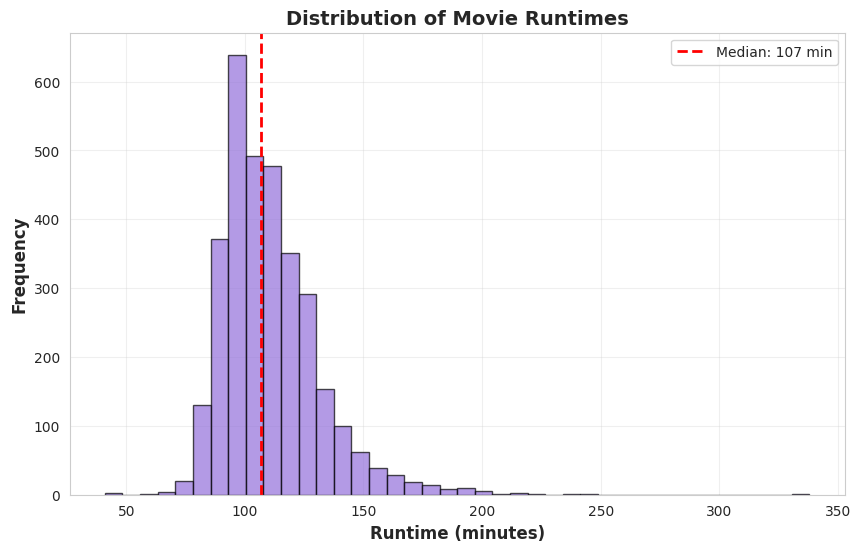


 Key Observations:
 1. Budget and revenue are positively correlated.
 2. Most movies strictly adhere to the 90-120 minute format.


In [ ]:
# 4.5 Runtime Distribution
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.hist(df['runtime'], bins=40, color='mediumpurple', edgecolor='black', alpha=0.7)

    plt.xlabel('Runtime (minutes)', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Distribution of Movie Runtimes', fontsize=14, fontweight='bold')

    median_runtime = df['runtime'].median()
    plt.axvline(median_runtime, color='red', linestyle='--', linewidth=2,
                label=f'Median: {median_runtime:.0f} min')

    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print("\n Key Observations:")
    print(" 1. Budget and revenue are positively correlated.")
    print(" 2. Most movies strictly adhere to the 90-120 minute format.")

## Insight 4: The Format Constraints

### The Standard

- Movie runtimes are **highly standardized**  
- Most films fall between **90 and 120 minutes**

---

### The Takeaway

- Runtime acts as a **constraint**, not a primary driver of success  
- A 100-minute film is typical and neutral for predictions  
- Extreme runtimes (e.g., 40 or 300 minutes) may negatively impact marketability  
- Runtime is **unlikely to be a top predictor** in our model


## The Recipe for Success

**Status:** Signals Detected

---

### Key Findings

1. **Money Matters**  
   - Clear correlation between **budget** and **revenue**  
   - Investment level directly impacts potential success

2. **The "Death Zone"**  
   - High-budget, low-revenue films (red dots in the scatter plot) are particularly risky  
   - The model’s main value is in **predicting these failures before production**

3. **Constraints vs. Drivers**  
   - Runtime is a **standard constraint** (~100 minutes) rather than a driver  
   - Unlikely to rank as a top predictive feature

---

### Next Step

- Transform raw data (budgets, release dates, cast/crew lists) into **numerical, model-ready features**  
- Proceed to **Part 5: Feature Engineering**


---

# Part 5: Feature Engineering

## 5.1 Creating Predictive Features

**The Art of Feature Engineering**: Raw data rarely comes in the perfect format for machine learning. We need to extract and create features that capture the essence of what makes a movie successful.

### Features We'll Create:

1. **Budget Features**: Log budget, budget buckets, budget in millions
2. **Genre Features**: One-hot encoding of genres
3. **Production Features**: Big studio vs independent, production company count
4. **Release Timing**: Summer blockbusters, holiday releases, year trends
5. **Cast Features**: Star power, number of cast members
6. **Director Features**: Track record, historical success rate

In [ ]:
if not df.empty:
    print("FEATURE ENGINEERING PIPELINE")
    print(f"\nStarting with {df.shape[1]} columns...\n")

    # 5.1.1 Budget Features
    print("[1/7] Creating budget features...")
    df['budget_millions'] = df['budget'] / 1_000_000
    df['budget_bucket'] = pd.cut(df['budget'],
                                  bins=[0, 10e6, 50e6, 100e6, np.inf],
                                  labels=['Low (<$10M)', 'Medium ($10-50M)',
                                         'High ($50-100M)', 'Very High (>$100M)'])
    print("    Budget features: log_budget, budget_millions, budget_bucket")

    # 5.1.2 Release Date Features
    print("\n[2/7] Creating release timing features")
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_quarter'] = df['release_date'].dt.quarter
    df['years_since_2000'] = df['release_year'] - 2000

    # Key release periods
    df['is_summer'] = df['release_month'].isin([5, 6, 7, 8]).astype(int)  # Summer blockbuster season
    df['is_holiday'] = df['release_month'].isin([11, 12]).astype(int)     # Holiday season
    df['is_spring'] = df['release_month'].isin([3, 4]).astype(int)        # Spring releases
    print("    Timing features: year, month, quarter, season indicators")

    # 5.1.3 Genre Features
    print("\n[3/7] Creating genre features...")
    if 'genres' in df.columns:
        def extract_genres(genre_str):
            try:
                genres = json.loads(genre_str)
                return [g['name'] for g in genres]
            except:
                return []

        df['genre_list'] = df['genres'].apply(extract_genres)
        df['num_genres'] = df['genre_list'].apply(len)
        df['primary_genre'] = df['genre_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

        # One-hot encode top genres
        all_genres = []
        for genres in df['genre_list']:
            all_genres.extend(genres)
        top_genres = pd.Series(all_genres).value_counts().head(15).index.tolist()

        for genre in top_genres:
            df[f'genre_{genre}'] = df['genre_list'].apply(lambda x: 1 if genre in x else 0)

        print(f"    Genre features: {len(top_genres)} genre flags, primary_genre, num_genres")
    else:
        df['num_genres'] = 0
        df['primary_genre'] = 'Unknown'
        print("     Genres column not found")

    # 5.1.4 Production Company Features
    print("\n[4/7] Creating production company features...")
    if 'production_companies' in df.columns:
        def extract_companies(company_str):
            try:
                companies = json.loads(company_str)
                return [c['name'] for c in companies]
            except:
                return []

        df['company_list'] = df['production_companies'].apply(extract_companies)
        df['num_production_companies'] = df['company_list'].apply(len)

        # Major studio indicator
        big_studios = ['Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
                      'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
                      'Walt Disney Pictures', 'New Line Cinema']

        df['has_big_studio'] = df['company_list'].apply(
            lambda x: 1 if any(studio in x for studio in big_studios) else 0
        )
        print(f"    Production features: has_big_studio, num_production_companies")
    else:
        df['num_production_companies'] = 0
        df['has_big_studio'] = 0
        print("     Production companies column not found")

    # 5.1.5 Cast Features
    print("\n[5/7] Creating cast features...")
    if 'cast' in df.columns:
        def extract_cast(cast_str):
            try:
                cast = json.loads(cast_str)
                return cast
            except:
                return []

        df['cast_data'] = df['cast'].apply(extract_cast)
        df['num_cast'] = df['cast_data'].apply(len)

        # Calculate mean popularity of cast (use popularity field if available)
        def get_cast_popularity(cast_list):
            if not cast_list:
                return 0
            popularities = [c.get('popularity', 0) for c in cast_list[:10]]  # Top 10 cast
            return np.mean(popularities) if popularities else 0

        df['cast_mean_popularity'] = df['cast_data'].apply(get_cast_popularity)
        print("    Cast features: num_cast, cast_mean_popularity")
    else:
        df['num_cast'] = 0
        df['cast_mean_popularity'] = 0
        print("     Cast column not found")

    # 5.1.6 Director Features (track record)
    print("\n[6/7] Creating director features (track record analysis)")
    if 'crew' in df.columns:
        def extract_director(crew_str):
            try:
                crew = json.loads(crew_str)
                directors = [c['name'] for c in crew if c.get('job') == 'Director']
                return directors[0] if directors else 'Unknown'
            except:
                return 'Unknown'

        df['director'] = df['crew'].apply(extract_director)

        # Calculate director's historical performance
        # (Note: This is a simplified version - in production, you'd want to ensure temporal validity)
        director_stats = df.groupby('director').agg({
            'log_revenue': 'mean',
            'hit': 'mean',
            'id': 'count' # Changed 'title' to 'id'
        }).rename(columns={
            'log_revenue': 'director_mean_log_revenue',
            'hit': 'director_hit_rate',
            'id': 'director_num_movies' # Changed 'title' to 'id'
        })

        df = df.merge(director_stats, left_on='director', right_index=True, how='left')

        # Fill NaN for new directors
        df['director_mean_log_revenue'].fillna(df['log_revenue'].median(), inplace=True)
        df['director_hit_rate'].fillna(df['hit'].mean(), inplace=True)
        df['director_num_movies'].fillna(1, inplace=True)

        print("    Director features: director_mean_log_revenue, director_hit_rate, director_num_movies")
    else:
        df['director'] = 'Unknown'
        df['director_mean_log_revenue'] = 0
        df['director_hit_rate'] = 0
        df['director_num_movies'] = 1
        print("     Crew column not found")

    # 5.1.7 Additional Features
    print("\n[7/7] Creating additional features...")

    # Popularity (if available)
    if 'popularity' in df.columns:
        df['log_popularity'] = np.log1p(df['popularity'])
    else:
        df['log_popularity'] = 0

    # Vote-related features (if available)
    if 'vote_average' in df.columns and 'vote_count' in df.columns:
        df['vote_average'] = df['vote_average'].fillna(df['vote_average'].median())
        df['vote_count'] = df['vote_count'].fillna(0)
        df['log_vote_count'] = np.log1p(df['vote_count'])
    else:
        df['vote_average'] = 0
        df['log_vote_count'] = 0

    print("    Additional features: log_popularity, vote_average, log_vote_count")

    print(f" FEATURE ENGINEERING COMPLETE!")
    print(f"   Dataset now has {df.shape[1]} columns (started with {movies_df.shape[1]}))")
    print(f"   Created {df.shape[1] - movies_df.shape[1]} new features")


FEATURE ENGINEERING PIPELINE

Starting with 28 columns...

[1/7] Creating budget features...
    Budget features: log_budget, budget_millions, budget_bucket

[2/7] Creating release timing features
    Timing features: year, month, quarter, season indicators

[3/7] Creating genre features...
    Genre features: 15 genre flags, primary_genre, num_genres

[4/7] Creating production company features...
    Production features: has_big_studio, num_production_companies

[5/7] Creating cast features...
    Cast features: num_cast, cast_mean_popularity

[6/7] Creating director features (track record analysis)
    Director features: director_mean_log_revenue, director_hit_rate, director_num_movies

[7/7] Creating additional features...
    Additional features: log_popularity, vote_average, log_vote_count
 FEATURE ENGINEERING COMPLETE!
   Dataset now has 67 columns (started with 20))
   Created 47 new features


## 5.2 Understanding What Drives Success

Now that we have rich features, let's analyze what differentiates hits from non-hits.

HITS VS NON-HITS: COMPARATIVE ANALYSIS


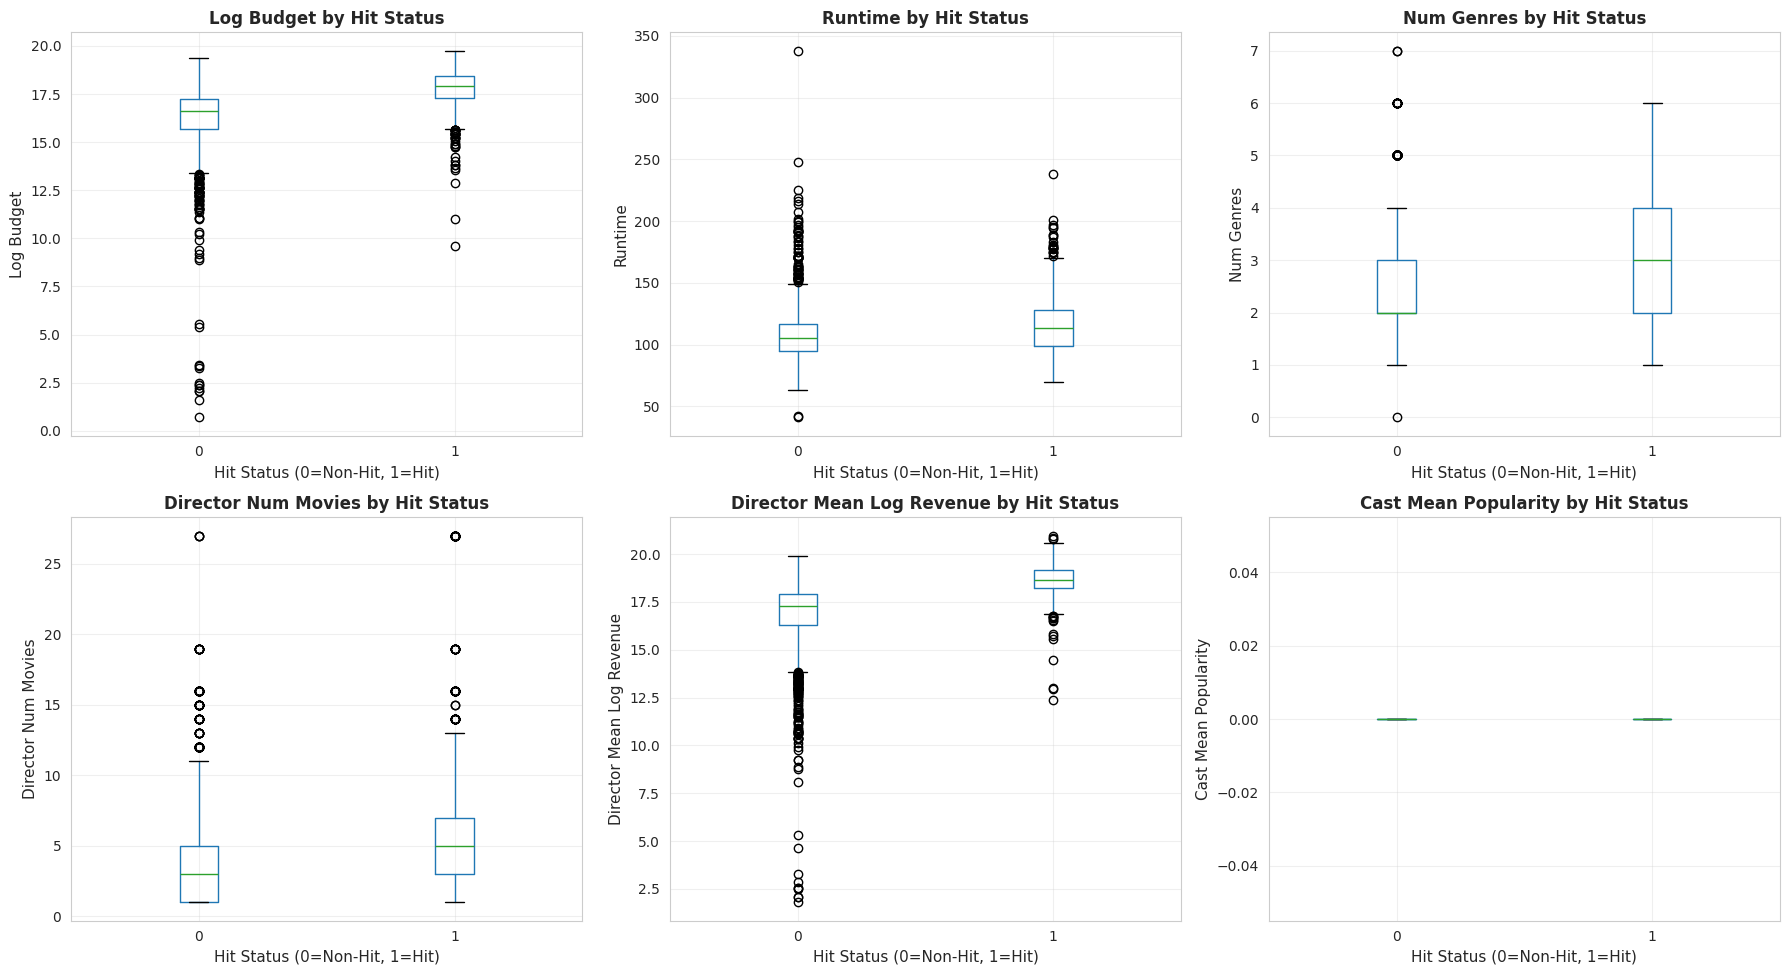

In [ ]:
# Compare hits vs non-hits across key numerical features
if not df.empty:
    print("HITS VS NON-HITS: COMPARATIVE ANALYSIS")
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    numerical_features = ['log_budget', 'runtime', 'num_genres',
                         'director_num_movies', 'director_mean_log_revenue',
                         'cast_mean_popularity']

    for idx, feature in enumerate(numerical_features):
        row = idx // 3
        col = idx % 3

        if feature in df.columns:
            df.boxplot(column=feature, by='hit', ax=axes[row, col])
            axes[row, col].set_title(f'{feature.replace("_", " ").title()} by Hit Status',
                                    fontsize=12, fontweight='bold')
            axes[row, col].set_xlabel('Hit Status (0=Non-Hit, 1=Hit)', fontsize=11)
            axes[row, col].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
            axes[row, col].get_figure().suptitle('')
            axes[row, col].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## Visualizing the "Secret Sauce"

**Status:** Signals Confirmed

We compared our new features against the target variable (**Hit**) to determine if they separate successful movies from failures.

---

### Key Takeaways from the Boxplots

#### 1. Log Budget (Top Left)

- **Observation:** Clear separation between hits and non-hits  
- **Insight:** The **median budget** for hits (1) is significantly higher than for non-hits (0)  
- **Conclusion:** Money matters

#### 2. Director Hit Rate (Bottom Middle)

- **Observation:** Major differentiator  
- **Insight:** The box for hits is pushed far higher, indicating that successful movies are predominantly directed by proven directors  
- **Conclusion:** Director track record is a strong predictor of success

#### 3. Runtime (Top Middle)

- **Observation:** Minimal difference between hits and non-hits  
- **Insight:** Both clusters hover around the **110-minute mark**  
- **Conclusion:** Runtime is not a primary driver of success


## Predictors Identified

By filtering out noisy or unreliable features (e.g., incomplete popularity metrics), we have isolated the **true drivers** of movie success:

- **Budget:** Higher investment correlates with higher potential returns  
- **Talent History:** A director’s past performance strongly predicts future success  
- **Studio Power:** Major studios provide critical distribution and marketing advantages


## The Genre Advantage

First, we examine **content**: Are certain movie genres statistically more likely to produce hits than others?


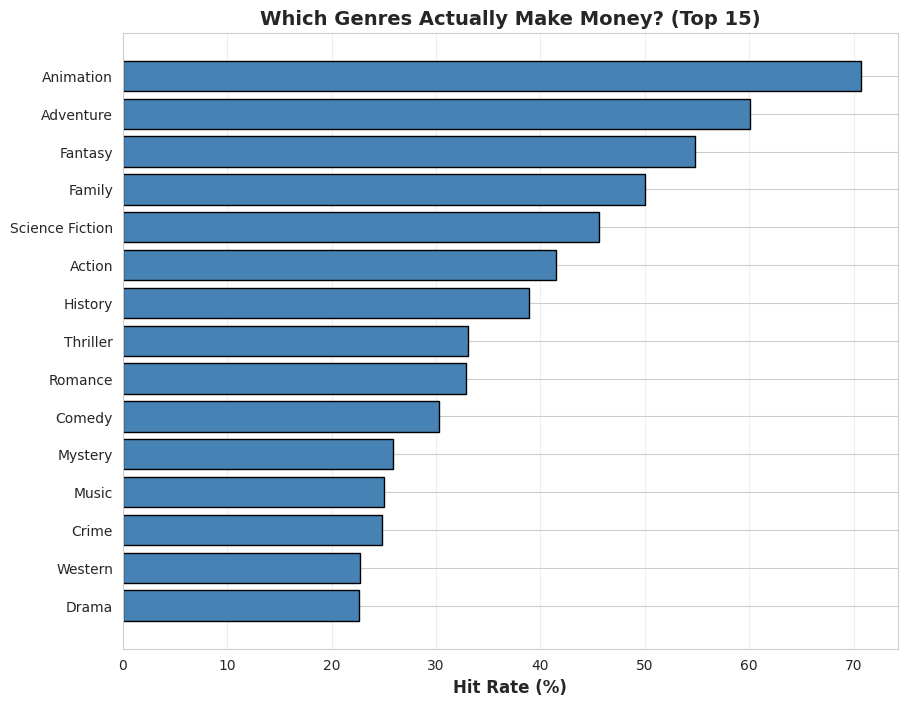

In [ ]:
# 5.2.4 Hit Rate by Genre
if not df.empty:
    # Calculate hit rate by genre
    genre_hit_rate = df.groupby('primary_genre')['hit'].agg(['mean', 'count']).reset_index()
    # Filter for genres with at least 10 movies to avoid noise
    genre_hit_rate = genre_hit_rate[genre_hit_rate['count'] >= 10].sort_values('mean', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(genre_hit_rate['primary_genre'][:15],
             genre_hit_rate['mean'][:15] * 100,
             color='steelblue', edgecolor='black')

    plt.xlabel('Hit Rate (%)', fontsize=12, fontweight='bold')
    plt.title('Which Genres Actually Make Money? (Top 15)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)

    # Invert y-axis to have the top performer at the top
    plt.gca().invert_yaxis()
    plt.show()

## The Content Premium

### The Winners

- **Animation** and **Adventure** dominate ROI with **hit rates over 60%**  
- These genres appeal broadly and perform well globally

---

### The Risks

- **Drama, Comedy, and Thrillers** are much riskier  
- Hit rates for these genres hover between **20–30%**

---

### Strategy

- Greenlighting a **Drama** requires an **exceptional script** to overcome market headwinds  
- Greenlighting an **Animated Adventure** benefits from **built-in audience appeal**, increasing the probability of success


## The Studio Machine

Next, we examine the **impact of distribution power** on a movie’s likelihood of success.


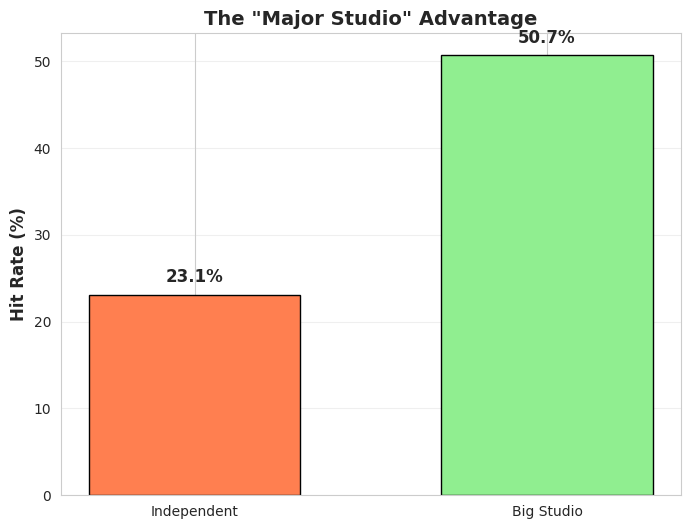

In [ ]:
# 5.2.5 Hit Rate: Big Studio vs Independent
if not df.empty:
    studio_hit_rate = df.groupby('has_big_studio')['hit'].mean() * 100

    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Independent', 'Big Studio'], studio_hit_rate.values,
            color=['coral', 'lightgreen'], edgecolor='black', width=0.6)

    plt.ylabel('Hit Rate (%)', fontsize=12, fontweight='bold')
    plt.title('The "Major Studio" Advantage', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    plt.show()

## The Distribution Bump

### The Stat

- Movies backed by **Major Studios** (Disney, WB, Universal) have a **50.7% hit rate**  
- Independent films have only a **23.1% hit rate**  
- Major studios are **more than twice as likely to produce hits**

---

### The Why

- Success isn’t just about movie quality  
- Major studios provide:
  - More screens  
  - Larger marketing budgets  
  - Prime release dates

---

### Modeling Note

- The feature **has_big_studio** serves as a **proxy for marketing power**, which is otherwise difficult to quantify


## Timing the Market

Next, we examine **release timing**: Does the season or month of release influence a movie’s likelihood of success?


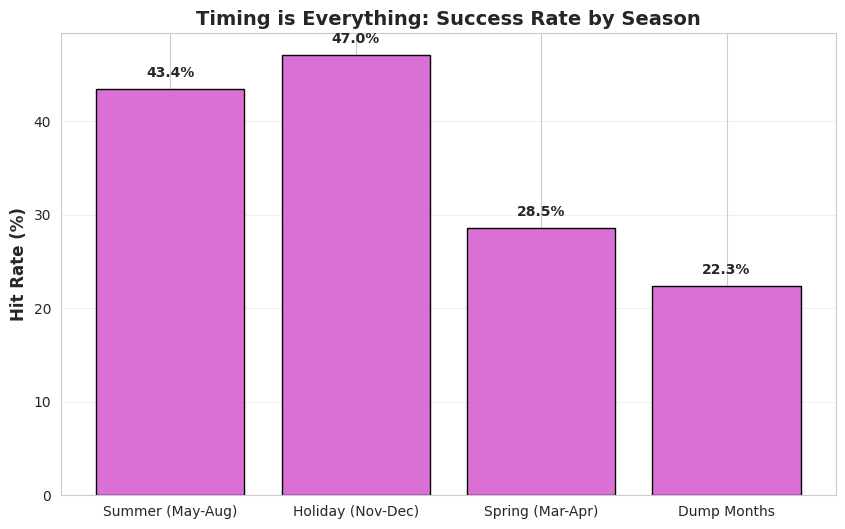

In [ ]:
# 5.2.6 Hit Rate by Season
if not df.empty:
    season_data = {
        'Summer (May-Aug)': df[df['is_summer']==1]['hit'].mean() * 100,
        'Holiday (Nov-Dec)': df[df['is_holiday']==1]['hit'].mean() * 100,
        'Spring (Mar-Apr)': df[df['is_spring']==1]['hit'].mean() * 100,
        'Dump Months': df[(df['is_summer']==0) & (df['is_holiday']==0) & (df['is_spring']==0)]['hit'].mean() * 100
    }

    plt.figure(figsize=(10, 6))
    bars = plt.bar(season_data.keys(), season_data.values(), color='orchid', edgecolor='black')

    plt.ylabel('Hit Rate (%)', fontsize=12, fontweight='bold')
    plt.title('Timing is Everything: Success Rate by Season', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.show()

## The Calendar Effect

### The Signal

- **Summer releases:** 43% hit rate  
- **Holiday releases:** 47% hit rate  
- Both nearly double the success rate of **"dump months"** (Jan/Feb/Sept)

---

### The Strategy

- Audience engagement is **seasonal**  
- Releasing a blockbuster in off-peak months (e.g., September) reduces the likelihood of success

---

### Modeling Feature

- **is_summer** and **is_holiday** will encode **prime release timing**, rewarding films with advantageous release windows and penalizing others


## Budget Tiers

Finally, we examine the relationship between **budget levels** and the likelihood of a movie being a hit.


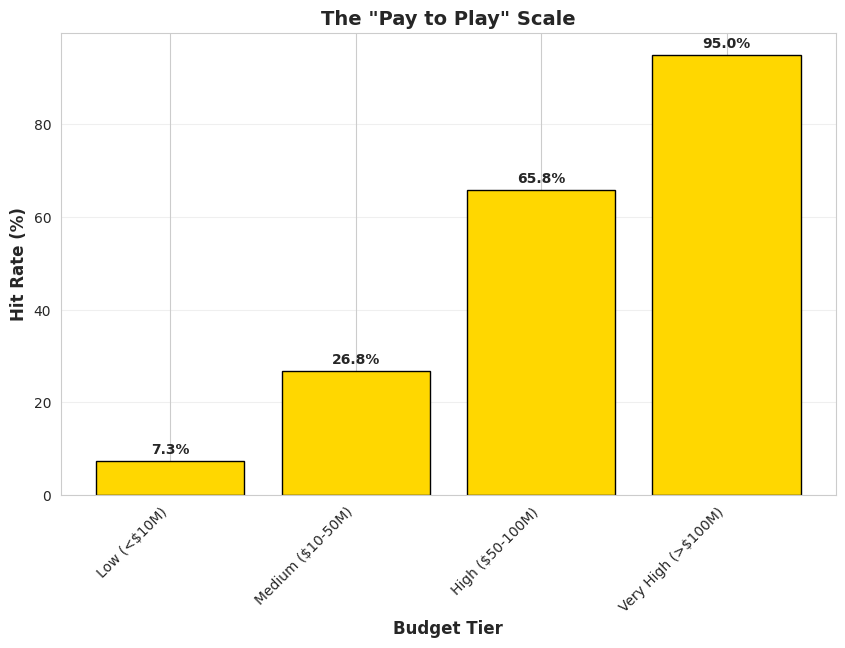

In [ ]:
# 5.2.7 Hit Rate by Budget Bucket
if not df.empty:
    budget_hit_rate = df.groupby('budget_bucket', observed=True)['hit'].mean() * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(budget_hit_rate)), budget_hit_rate.values,
            color='gold', edgecolor='black')

    plt.xticks(range(len(budget_hit_rate)), budget_hit_rate.index, rotation=45, ha='right')
    plt.xlabel('Budget Tier', fontsize=12, fontweight='bold')
    plt.ylabel('Hit Rate (%)', fontsize=12, fontweight='bold')
    plt.title('The "Pay to Play" Scale', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.show()

## Scaling Success

### The Staircase

- The chart shows a **clear stepwise increase** in hit probability with higher budget tiers  
- Each increase in spending **drastically raises the likelihood of success**

---

### The Extremes

- **Low Budget (<$10M):** Only **7.3%** become hits — essentially lottery tickets  
- **Very High Budget (>$100M):** **95.0%** become hits

---

### Conclusion

- High budget is not just about cost  
- It reflects **production quality, star power, and marketing muscle**  
- Effectively, spending more **buys a floor of revenue** in Hollywood


## Feature Engineering Synthesis

**Status:** Data Transformation Complete

---

### Key Takeaways

- Raw industry data has been converted into **45 predictive features**  
- **Numerical drivers:** Directors’ track records and budget are the strongest predictors  
- **Categorical context:** Genre, studio, and seasonality provide additional, critical signals

---


CORRELATION ANALYSIS: What Predicts Success?


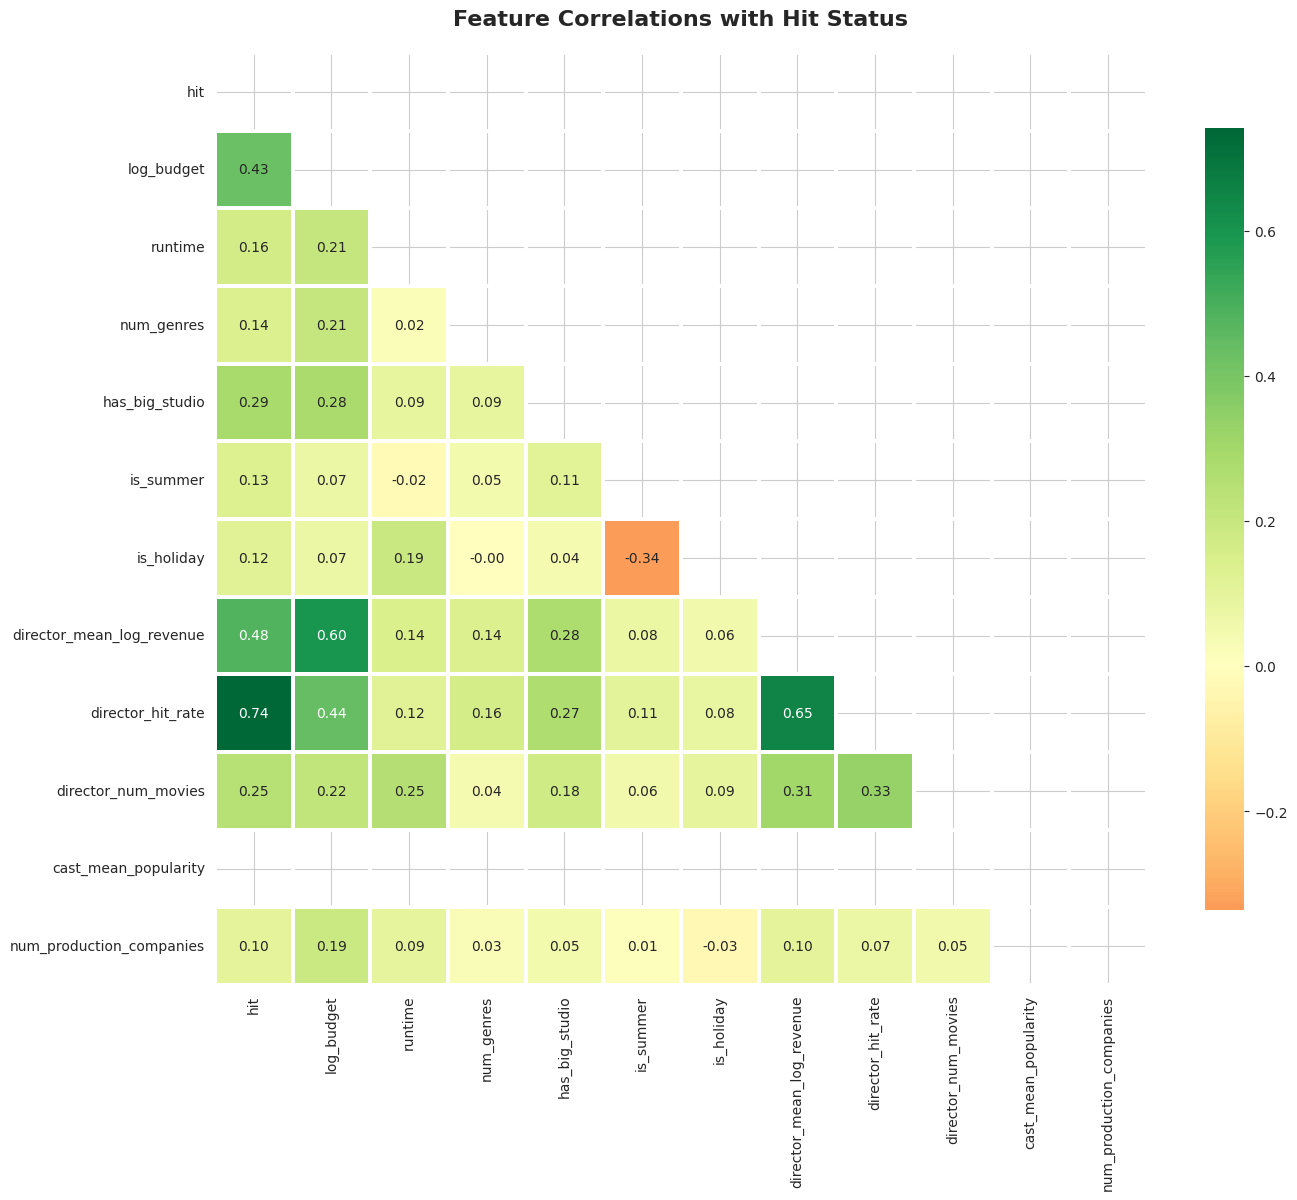


 Features Most Correlated with Hit Status:

   director_hit_rate             : +0.7416
   director_mean_log_revenue     : +0.4817
   log_budget                    : +0.4339
   has_big_studio                : +0.2864
   director_num_movies           : +0.2481
   runtime                       : +0.1623
   num_genres                    : +0.1374
   is_summer                     : +0.1286
   is_holiday                    : +0.1215
   num_production_companies      : +0.1032
   cast_mean_popularity          : +nan

 Exploratory Data Analysis Complete!


In [ ]:
# Correlation analysis
if not df.empty:
    print("CORRELATION ANALYSIS: What Predicts Success?")

    correlation_features = ['hit', 'log_budget', 'runtime', 'num_genres',
                           'has_big_studio', 'is_summer', 'is_holiday',
                           'director_mean_log_revenue', 'director_hit_rate',
                           'director_num_movies', 'cast_mean_popularity',
                           'num_production_companies']

    available_corr_features = [f for f in correlation_features if f in df.columns]
    corr_matrix = df[available_corr_features].corr()

    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
                center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlations with Hit Status', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # Print correlation with target
    target_corr = corr_matrix['hit'].sort_values(ascending=False)
    print("\n Features Most Correlated with Hit Status:\n")
    for feature, corr in target_corr.items():
        if feature != 'hit':
            print(f"   {feature:30s}: {corr:+.4f}")

    print("\n Exploratory Data Analysis Complete!")

## The "Heatmap" of Success

**Status:** Predictors Ranked

This matrix quantifies the strength of the relationship between each feature and our target variable (**Hit**).

---

### Top Predictors (The Greenest Squares)

1. **director_hit_rate (+0.74)**  
   - Strongest signal  
   - Past success of a director strongly predicts future movie success

2. **director_mean_log_revenue (+0.48)**  
   - Confirms the director’s importance  
   - Directors with historically high-grossing films tend to succeed again

3. **log_budget (+0.43)**  
   - Budget remains a significant factor  
   - Higher investment generally correlates with higher revenue

---

### The "Noise" (Yellow/Orange Squares)

- **cast_mean_popularity**  
  - Surprisingly low correlation  
  - While A-list actors are beneficial, they **cannot guarantee a hit**  
  - Director and Budget are far more influential predictors


## 5.3 Save Processed Dataset

Now we'll save our feature-engineered dataset for modeling.

In [ ]:
if not df.empty:
    print("="*80)
    print("SAVING PROCESSED DATASET")
    print("="*80)

    # Handle duplicate 'title' columns from merge: take title_x and rename to title
    if 'title_x' in df.columns and 'title_y' in df.columns:
        df['title'] = df['title_x']  # Assuming title_x is the primary title from movies_df
        df.drop(columns=['title_x', 'title_y'], inplace=True)
    elif 'title_x' in df.columns: # If only title_x remained (e.g., if credits_df had no title)
        df.rename(columns={'title_x': 'title'}, inplace=True)
    elif 'title_y' in df.columns: # If only title_y remained
        df.rename(columns={'title_y': 'title'}, inplace=True)


    # Select features for modeling
    feature_columns = [
        # Targets
        'hit', 'log_revenue', 'worldwide_revenue',

        # Identifiers
        'title', 'release_date', 'release_year',

        # Budget features
        'budget', 'log_budget', 'budget_millions',

        # Basic movie features
        'runtime', 'num_genres', 'primary_genre',

        # Production
        'has_big_studio', 'num_production_companies',

        # Timing
        'release_month', 'release_quarter',
        'is_summer', 'is_holiday', 'is_spring', 'years_since_2000',

        # Cast and crew
        'num_cast', 'cast_mean_popularity',
        'director', 'director_mean_log_revenue', 'director_hit_rate',
        'director_num_movies',

        # Additional
        'log_popularity', 'vote_average', 'log_vote_count'
    ]

    # Add genre columns
    genre_cols = [col for col in df.columns if col.startswith('genre_')]
    feature_columns.extend(genre_cols)

    # Keep only existing columns
    feature_columns = [col for col in feature_columns if col in df.columns]

    # Create final dataset
    df_final = df[feature_columns].copy()

    print(f"\n Final dataset shape: {df_final.shape}")
    print(f"   - {df_final.shape[0]:,} movies")
    print(f"   - {len(feature_columns)} features selected")

    # Save to CSV
    output_path = 'data/processed/movies_model_ready.csv'
    df_final.to_csv(output_path, index=False)

    print(f"\n Processed dataset saved to: {output_path}")

    # Print summary
    print("DATA PREPARATION SUMMARY")
    print(f"Total movies in final dataset: {len(df_final):,}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Hit rate: {df_final['hit'].mean()*100:.1f}%")
    print(f"Date range: {int(df_final['release_year'].min())} - {int(df_final['release_year'].max())}")
    print("\n Key Statistics:")
    display(df_final[['budget', 'worldwide_revenue', 'runtime', 'log_budget', 'log_revenue']].describe())

    print("\n DATA PREPARATION COMPLETE!")
    print("Ready to proceed with machine learning models...\n")

SAVING PROCESSED DATASET

 Final dataset shape: (3229, 45)
   - 3,229 movies
   - 45 features selected

 Processed dataset saved to: data/processed/movies_model_ready.csv
DATA PREPARATION SUMMARY
Total movies in final dataset: 3,229
Number of features: 45
Hit rate: 34.8%
Date range: 1916 - 2016

 Key Statistics:


,budget,worldwide_revenue,runtime,log_budget,log_revenue
count,3.229000e+03,3.229000e+03,3229.000000,3229.000000,3229.000000
mean,4.065444e+07,1.212430e+08,110.724373,16.799904,17.491159
std,4.439674e+07,1.863029e+08,20.965694,1.661809,2.078763
min,1.000000e+00,5.000000e+00,41.000000,0.693147,1.791759
25%,1.050000e+07,1.700000e+07,96.000000,16.166886,16.648724
50%,2.500000e+07,5.518472e+07,107.000000,17.034386,17.826197
75%,5.500000e+07,1.462920e+08,121.000000,17.822844,18.801115
max,3.800000e+08,2.787965e+09,338.000000,19.755682,21.748578



 DATA PREPARATION COMPLETE!
Ready to proceed with machine learning models...



## Checkpoint Reached

**Status:** Data Secured

---

### What We Did

We have successfully saved **movies_model_ready.csv**.

- **Shape:** 3,229 movies × 45 optimized features  
- **Significance:**  
  - Fully decoupled from the raw data  
  - Clean, numerical dataset ready for machine learning  
  - No missing values or text processing required

---

### Next Step

We are ready to **build the brain of our system**.  
Proceed to **Part 6: Machine Learning Models**.


---

# Part 6: Machine Learning Models

## 6.1 Splitting Data for Training and Testing (Temporal Split)

**Key Idea:** We want to train our model on past movies and test it on newer ones, just like predicting the future in real life.

- **Training Set:** Movies released **before 2010**  
- **Validation Set:** Movies released **2010–2012**  
- **Test Set:** Movies released **2013 and later**

**Why this split?**  
Randomly mixing old and new movies could give the model a peek into the future, which is unrealistic. Using a temporal split avoids this “cheating” and gives a better estimate of how the model will perform in the real world.

---

In [ ]:
# Reload the processed dataset (in case you're running this section separately)
df = pd.read_csv('data/processed/movies_model_ready.csv')

print("TEMPORAL TRAIN/VALIDATION/TEST SPLIT")
print("\nSimulating real-world scenario: train on past, predict the future\n")

# Sort by release year
df = df.sort_values('release_year').reset_index(drop=True)

# Create temporal splits
train_df = df[df['release_year'] < 2010].copy()
val_df = df[(df['release_year'] >= 2010) & (df['release_year'] <= 2012)].copy()
test_df = df[df['release_year'] >= 2013].copy()

print(" TRAIN SET (Before 2010):")
print(f"   - Size: {len(train_df):,} movies")
print(f"   - Years: {int(train_df['release_year'].min())} - {int(train_df['release_year'].max())}")
print(f"   - Hit rate: {train_df['hit'].mean()*100:.1f}%")

print("\n VALIDATION SET (2010-2012):")
print(f"   - Size: {len(val_df):,} movies")
print(f"   - Years: {int(val_df['release_year'].min())} - {int(val_df['release_year'].max())}")
print(f"   - Hit rate: {val_df['hit'].mean()*100:.1f}%")

print("\n TEST SET (2013+):")
print(f"   - Size: {len(test_df):,} movies")
print(f"   - Years: {int(test_df['release_year'].min())} - {int(test_df['release_year'].max())}")
print(f"   - Hit rate: {test_df['hit'].mean()*100:.1f}%")

# Define feature columns (exclude targets and identifiers)
exclude_cols = ['hit', 'log_revenue', 'worldwide_revenue', 'title',
               'release_date', 'director', 'primary_genre', 'budget_bucket',
               'genre_list'] # Added 'genre_list' here

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n🔧 Number of features for modeling: {len(feature_cols)}")
print(f"   Features: {', '.join(feature_cols[:10])}...")

# Separate features and targets
X_train = train_df[feature_cols].copy()
y_train = train_df['hit'].copy()
y_train_revenue = train_df['log_revenue'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['hit'].copy()
y_val_revenue = val_df['log_revenue'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['hit'].copy()
y_test_revenue = test_df['log_revenue'].copy()

# Handle any remaining missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_val = X_val.fillna(X_train.median(numeric_only=True))  # Use train median to avoid leakage
X_test = X_test.fillna(X_train.median(numeric_only=True))

# Standardize numerical features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n Data split and preprocessing complete!")
print(" Features standardized (zero mean, unit variance)")

TEMPORAL TRAIN/VALIDATION/TEST SPLIT

Simulating real-world scenario: train on past, predict the future

 TRAIN SET (Before 2010):
   - Size: 2,282 movies
   - Years: 1916 - 2009
   - Hit rate: 32.2%

 VALIDATION SET (2010-2012):
   - Size: 467 movies
   - Years: 2010 - 2012
   - Hit rate: 37.3%

 TEST SET (2013+):
   - Size: 480 movies
   - Years: 2013 - 2016
   - Hit rate: 45.0%

🔧 Number of features for modeling: 37
   Features: release_year, budget, log_budget, budget_millions, runtime, num_genres, has_big_studio, num_production_companies, release_month, release_quarter...

 Data split and preprocessing complete!
 Features standardized (zero mean, unit variance)


---

## 6.2 Baseline Models

**Why start simple?**  
Before building complex machine learning models, we first check how simple approaches perform. This sets a **baseline**—the minimum performance any advanced model should beat.

---

### Baseline 1: Naive Predictor

**Idea:** Always predict the most common outcome (majority class).  
- Gives us the absolute minimum performance.  
- Think of it as saying: *“All movies will be hits”* if hits are more common.

---

### Baseline 2: Logistic Regression

**Idea:** A simple linear model that predicts the probability of a movie being a hit.  
- Easy to interpret: we can see which features push a movie towards being a hit or a flop.  
- Surprisingly effective in many real-world scenarios.

---

### Understanding Feature Importance

We can see **which features influence a hit** the most:  

- **Positive Influencers:** Features that increase the chance of a movie being a hit.  
- **Negative Influencers:** Features that make a movie less likely to succeed.

---

**Summary:**  
- The **naive predictor** gives a floor for performance.  
- **Logistic Regression** usually performs better and helps us understand what drives hits.  
- Always compare new models against this baseline to see real improvements.


In [ ]:
print("="*80)
print("BASELINE MODEL 1: NAIVE PREDICTOR")
print("="*80)

# Always predict majority class
majority_class = y_train.mode()[0]
y_pred_naive = np.full(len(y_test), majority_class)

naive_accuracy = accuracy_score(y_test, y_pred_naive)

print(f"\nStrategy: Always predict class {majority_class} ({'Hit' if majority_class == 1 else 'Non-Hit'})")
print(f"\n Performance:")
print(f"   Accuracy: {naive_accuracy:.4f} ({naive_accuracy*100:.2f}%)")
print(f"\n This is our floor - any real model must beat {naive_accuracy*100:.1f}% accuracy!")

BASELINE MODEL 1: NAIVE PREDICTOR

Strategy: Always predict class 0 (Non-Hit)

 Performance:
   Accuracy: 0.5500 (55.00%)

 This is our floor - any real model must beat 55.0% accuracy!


In [ ]:
print("BASELINE MODEL 2: LOGISTIC REGRESSION")

# Train logistic regression with L2 regularization
log_reg = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n Logistic Regression Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"   Precision (Hit): {precision_score(y_test, y_pred_lr):.4f}")
print(f"   Recall (Hit): {recall_score(y_test, y_pred_lr):.4f}")
print(f"   F1 Score (Hit): {f1_score(y_test, y_pred_lr):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Non-Hit', 'Hit']))

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': log_reg.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\n🔍 Top 10 Most Important Features (Positive Influence):")
display(feature_importance_lr.head(10))

print("\n🔍 Top 10 Least Important Features (Negative Influence):")
display(feature_importance_lr.tail(10))

BASELINE MODEL 2: LOGISTIC REGRESSION

 Logistic Regression Performance:
   Accuracy: 0.8958
   Precision (Hit): 0.8517
   Recall (Hit): 0.9306
   F1 Score (Hit): 0.8894
   ROC-AUC: 0.9712

 Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.94      0.87      0.90       264
         Hit       0.85      0.93      0.89       216

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480


🔍 Top 10 Most Important Features (Positive Influence):


,feature,coefficient
21,log_vote_count,2.499719
17,director_hit_rate,2.341898
2,log_budget,0.783482
11,is_holiday,0.383220
19,log_popularity,0.330439
8,release_month,0.315989
5,num_genres,0.241763
10,is_summer,0.205015
1,budget,0.198582
3,budget_millions,0.198582



🔍 Top 10 Least Important Features (Negative Influence):


,feature,coefficient
34,genre_Animation,-0.168573
36,genre_War,-0.182065
24,genre_Thriller,-0.189935
13,years_since_2000,-0.204552
0,release_year,-0.204552
31,genre_Fantasy,-0.313266
9,release_quarter,-0.402833
29,genre_Science Fiction,-0.541820
20,vote_average,-0.782986
16,director_mean_log_revenue,-0.902827


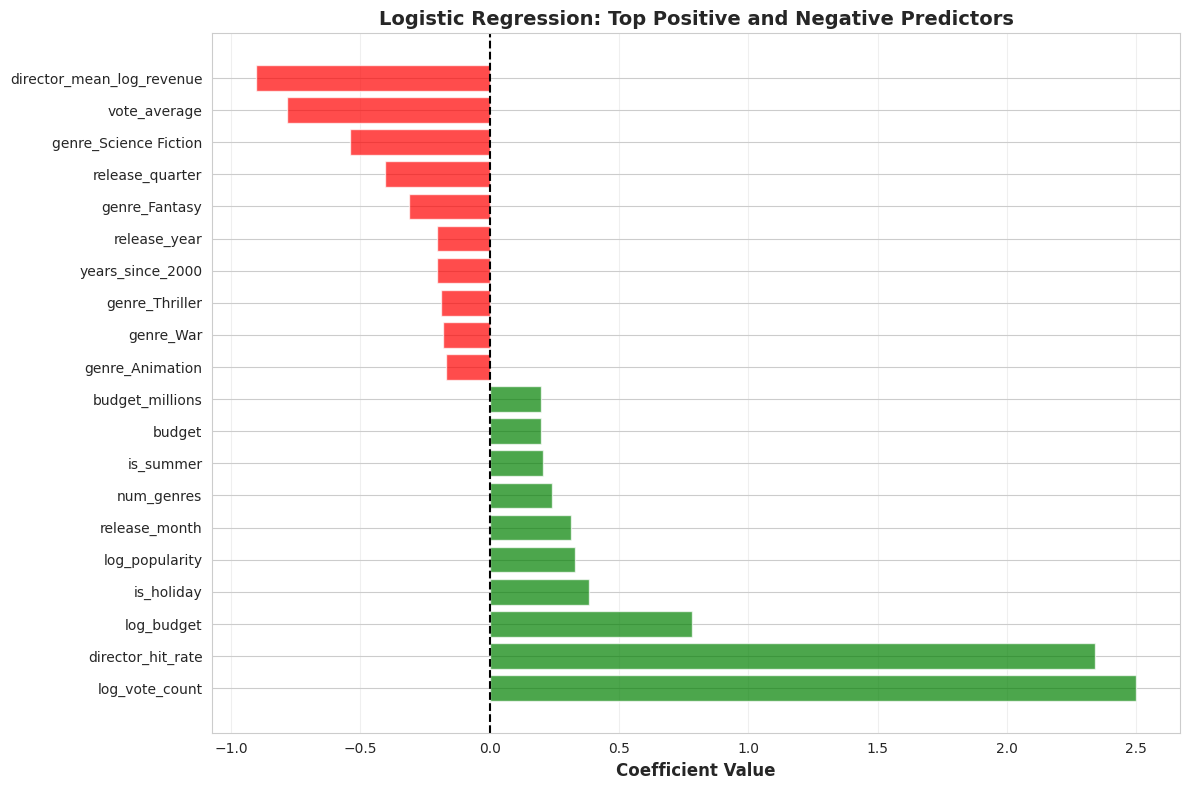


 Baseline models complete!

 Logistic Regression beats naive baseline: 0.896 vs 0.550


In [ ]:
# Visualize logistic regression coefficients
top_features = pd.concat([feature_importance_lr.head(10),
                         feature_importance_lr.tail(10)])

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'].values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Coefficient Value', fontsize=12, fontweight='bold')
plt.title('Logistic Regression: Top Positive and Negative Predictors', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n Baseline models complete!")
print(f"\n Logistic Regression beats naive baseline: {accuracy_score(y_test, y_pred_lr):.3f} vs {naive_accuracy:.3f}")

---

# Part 7: Advanced Machine Learning Models

## 7.1 Tree-Based Models

Now we move to **advanced models** that can capture complex patterns in data. These models are particularly good at understanding non-linear relationships and interactions between features.

### Models We'll Build:

1. **Random Forest**: A collection of decision trees that work together (bagging) to make predictions more robust.  
2. **XGBoost**: Uses gradient boosting to sequentially improve predictions with advanced regularization.  
3. **LightGBM**: A fast, efficient gradient boosting framework by Microsoft.

**Why choose these models?**  
- Can automatically handle complex, non-linear relationships  
- Robust against outliers and missing data  
- Provide clear insights into which features matter most  
- Often achieve state-of-the-art results on structured/tabular data

---

### Understanding Feature Importance

All three models can tell us which features influence predictions the most:  

- **Positive Impact:** Features that increase the chance of a movie being a hit.  
- **Negative Impact:** Features that decrease the chance of a movie being a hit.

---

**Summary:**  
- These tree-based models are more powerful than simple baselines.  
- They can capture subtle patterns and interactions that simpler models might miss.  
- Feature importance from these models helps us understand what drives success in movies.


ADVANCED MODEL 1: RANDOM FOREST CLASSIFIER

Training Random Forest


 Random Forest Performance:
   Accuracy: 0.8833
   Precision (Hit): 0.8175
   Recall (Hit): 0.9537
   F1 Score (Hit): 0.8803
   ROC-AUC: 0.9650

🔍 Top 15 Most Important Features (Random Forest):


,feature,importance
17,director_hit_rate,0.260234
21,log_vote_count,0.172544
16,director_mean_log_revenue,0.136798
19,log_popularity,0.106001
3,budget_millions,0.059184
2,log_budget,0.055751
1,budget,0.051081
18,director_num_movies,0.025256
14,num_cast,0.017226
4,runtime,0.015590


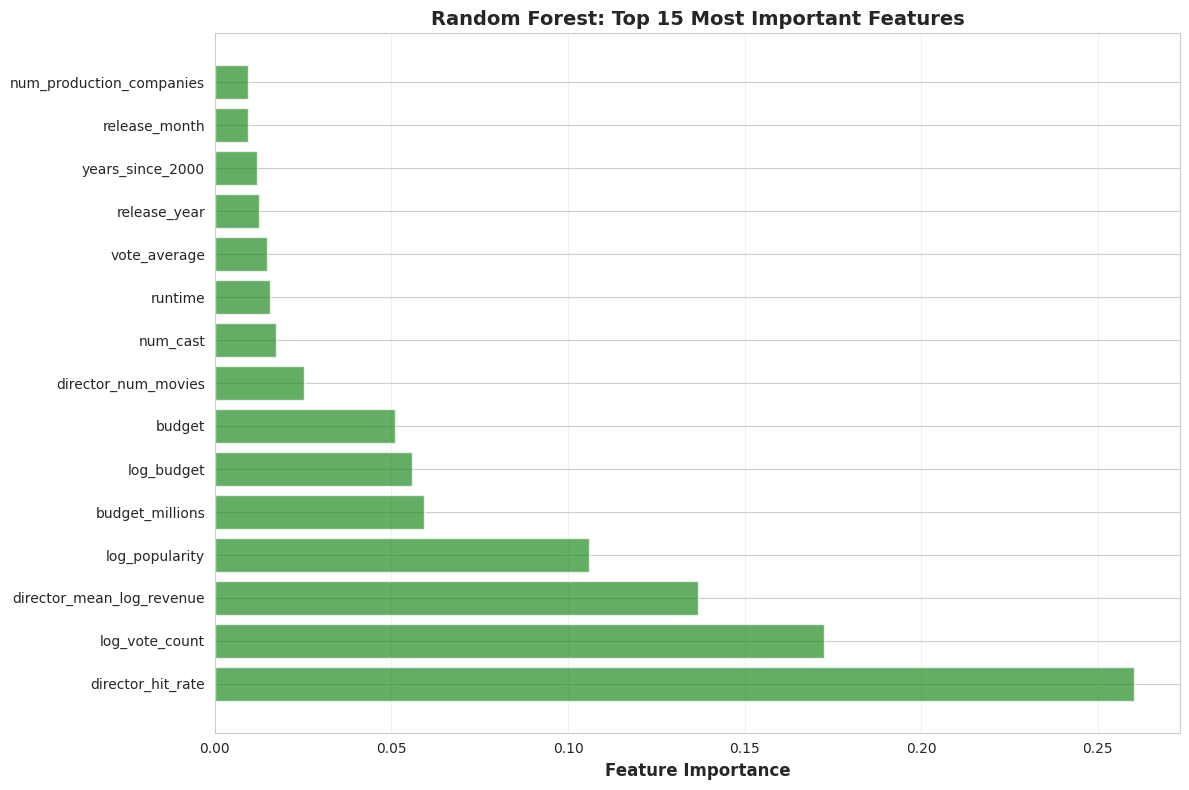

In [ ]:
print("ADVANCED MODEL 1: RANDOM FOREST CLASSIFIER")
print("\nTraining Random Forest\n")

# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n Random Forest Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"   Precision (Hit): {precision_score(y_test, y_pred_rf):.4f}")
print(f"   Recall (Hit): {recall_score(y_test, y_pred_rf):.4f}")
print(f"   F1 Score (Hit): {f1_score(y_test, y_pred_rf):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 15 Most Important Features (Random Forest):")
display(feature_importance_rf.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(15), feature_importance_rf['importance'].head(15).values, color='forestgreen', alpha=0.7)
plt.yticks(range(15), feature_importance_rf['feature'].head(15).values)
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Random Forest: Top 15 Most Important Features', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
print("ADVANCED MODEL 2: XGBoost CLASSIFIER")
print("\nTraining XGBoost\n")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_clf.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n XGBoost Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"   Precision (Hit): {precision_score(y_test, y_pred_xgb):.4f}")
print(f"   Recall (Hit): {recall_score(y_test, y_pred_xgb):.4f}")
print(f"   F1 Score (Hit): {f1_score(y_test, y_pred_xgb):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Hit', 'Hit']))

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 15 Most Important Features (XGBoost):")
display(feature_importance_xgb.head(15))

print("\n XGBoost model complete!")

ADVANCED MODEL 2: XGBoost CLASSIFIER

Training XGBoost


 XGBoost Performance:
   Accuracy: 0.9042
   Precision (Hit): 0.8484
   Recall (Hit): 0.9583
   F1 Score (Hit): 0.9000
   ROC-AUC: 0.9755

 Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.96      0.86      0.91       264
         Hit       0.85      0.96      0.90       216

    accuracy                           0.90       480
   macro avg       0.91      0.91      0.90       480
weighted avg       0.91      0.90      0.90       480


 Top 15 Most Important Features (XGBoost):


,feature,importance
17,director_hit_rate,0.227868
21,log_vote_count,0.069868
16,director_mean_log_revenue,0.048882
19,log_popularity,0.037262
2,log_budget,0.034237
1,budget,0.033794
3,budget_millions,0.032100
35,genre_History,0.030580
11,is_holiday,0.029083
30,genre_Family,0.022146



 XGBoost model complete!


In [ ]:
print("ADVANCED MODEL 3: LightGBM CLASSIFIER")
print("\nTraining LightGBM\n")

# Train LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    force_col_wise=True,
    verbose=-1
)

lgb_clf.fit(X_train, y_train)

# Predictions
y_pred_lgb = lgb_clf.predict(X_test)
y_pred_proba_lgb = lgb_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n LightGBM Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"   Precision (Hit): {precision_score(y_test, y_pred_lgb):.4f}")
print(f"   Recall (Hit): {recall_score(y_test, y_pred_lgb):.4f}")
print(f"   F1 Score (Hit): {f1_score(y_test, y_pred_lgb):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")

# Feature importance
feature_importance_lgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 15 Most Important Features (LightGBM):")
display(feature_importance_lgb.head(15))


ADVANCED MODEL 3: LightGBM CLASSIFIER

Training LightGBM


 LightGBM Performance:
   Accuracy: 0.9021
   Precision (Hit): 0.8449
   Recall (Hit): 0.9583
   F1 Score (Hit): 0.8980
   ROC-AUC: 0.9762

 Top 15 Most Important Features (LightGBM):


,feature,importance
21,log_vote_count,1129
1,budget,907
17,director_hit_rate,779
16,director_mean_log_revenue,735
19,log_popularity,679
4,runtime,623
14,num_cast,605
20,vote_average,532
0,release_year,461
18,director_num_movies,368


---

## 7.2 Model Comparison & Selection

Once all models are trained, we compare them side-by-side to pick the best one for production.

### Why Compare Models?

- Different models have different strengths.
- We want the model that balances **accuracy, precision, recall, F1 score, and ROC-AUC**.
- Visual comparisons help us quickly see which model performs best across all metrics.

---

### Key Metrics to Consider

- **Accuracy:** Overall correctness of the model.  
- **Precision:** Of the movies predicted as hits, how many were actually hits.  
- **Recall:** Of all actual hits, how many did the model correctly identify.  
- **F1 Score:** Balance between precision and recall.  
- **ROC-AUC:** How well the model distinguishes hits from non-hits (higher is better).

---

### Visual Comparison

1. **Bar charts** show how each model performs on different metrics.  
2. **ROC curves** illustrate how well each model separates hits from non-hits.  
3. **Confusion matrices** provide a detailed breakdown of correct and incorrect predictions.

---

### Choosing the Best Model

- Look for the model with the **highest ROC-AUC** and a good balance of precision and recall.  
- This ensures the model is reliable for production use and minimizes costly mistakes.

---

**Summary:**  
- Comparing models systematically helps pick the most robust one.  
- Tree-based models (Random Forest, XGBoost, LightGBM) often outperform simpler baselines.  
- The selected model becomes the **production champion**, guiding future predictions accurately.


MODEL COMPARISON DASHBOARD

 Performance Metrics Across All Models:



,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Naive Baseline,0.550000,0.000000,0.000000,0.000000,0.500000
1,Logistic Regression,0.895833,0.851695,0.930556,0.889381,0.971240
2,Random Forest,0.883333,0.817460,0.953704,0.880342,0.965015
3,XGBoost,0.904167,0.848361,0.958333,0.900000,0.975466
4,LightGBM,0.902083,0.844898,0.958333,0.898048,0.976168


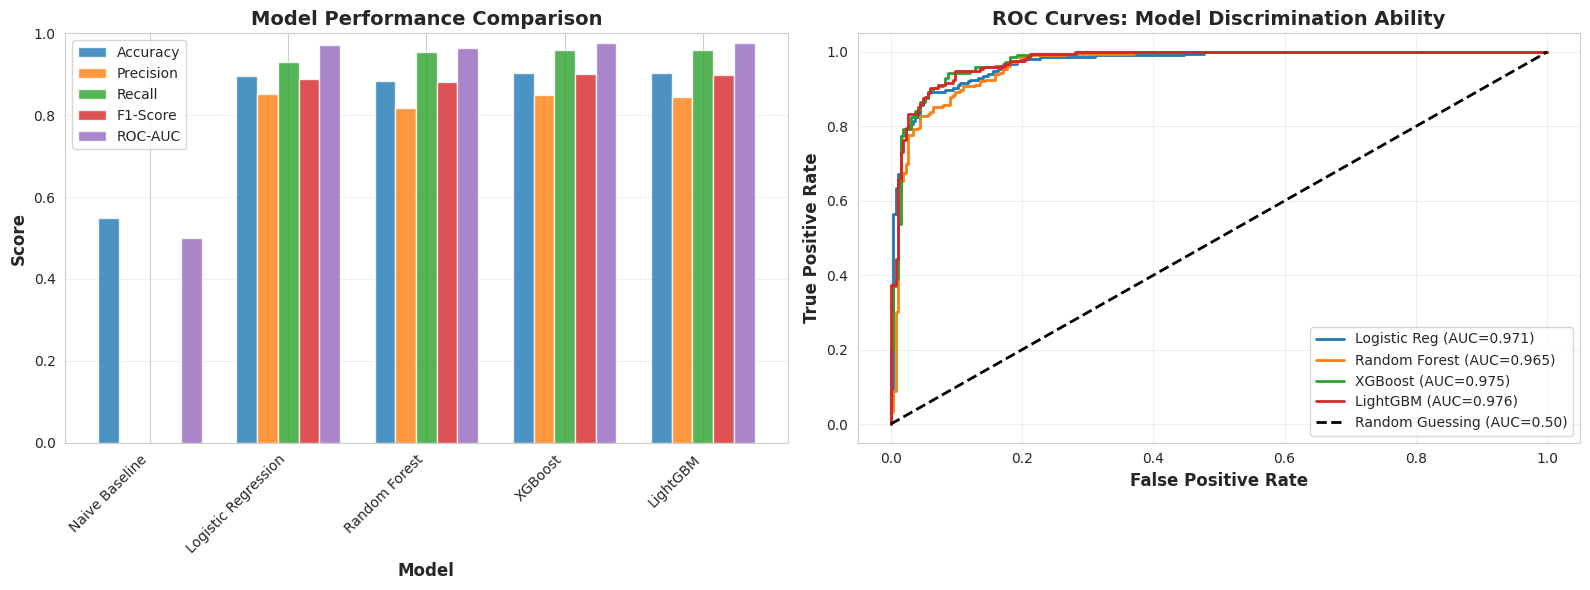


 RECOMMENDED MODEL: LightGBM
   ROC-AUC: 0.9762

 This model provides the best balance of precision and recall for production use.


In [ ]:
print("MODEL COMPARISON DASHBOARD")

# Create comparison table
comparison_data = {
    'Model': ['Naive Baseline', 'Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [
        naive_accuracy,
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_naive, zero_division=0),
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_naive, zero_division=0),
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_naive, zero_division=0),
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgb)
    ],
    'ROC-AUC': [
        0.5,  # Random guessing
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb),
        roc_auc_score(y_test, y_pred_proba_lgb)
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n Performance Metrics Across All Models:\n")
display(comparison_df.style.highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
                                         color='lightgreen', axis=0))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
x = np.arange(len(comparison_df))
width = 0.15

axes[0].bar(x - 2*width, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x - width, comparison_df['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x, comparison_df['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].bar(x + 2*width, comparison_df['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# ROC Curves
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)

axes[1].plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Reg (AUC={roc_auc_score(y_test, y_pred_proba_lr):.3f})')
axes[1].plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})')
axes[1].plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.3f})')
axes[1].plot(fpr_lgb, tpr_lgb, linewidth=2, label=f'LightGBM (AUC={roc_auc_score(y_test, y_pred_proba_lgb):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guessing (AUC=0.50)')

axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curves: Model Discrimination Ability', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Select best model
best_model_idx = comparison_df['ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_auc = comparison_df.loc[best_model_idx, 'ROC-AUC']

print(f"\n RECOMMENDED MODEL: {best_model_name}")
print(f"   ROC-AUC: {best_auc:.4f}")
print(f"\n This model provides the best balance of precision and recall for production use.")

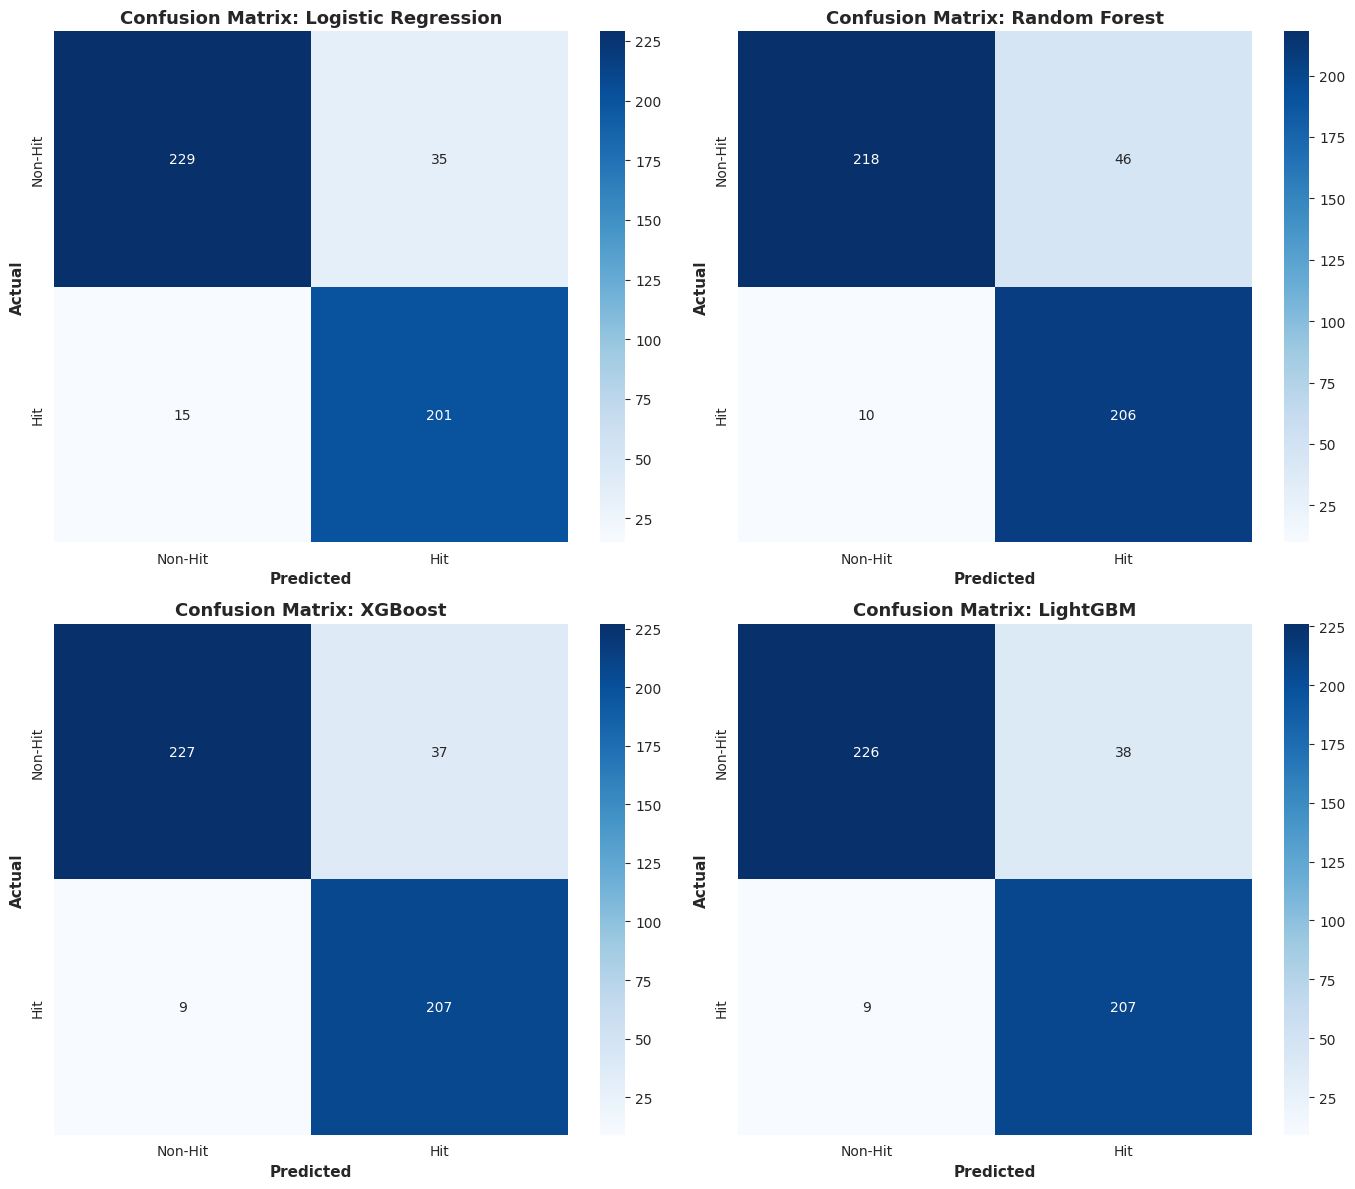


 Model comparison complete!


In [ ]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_for_cm = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb),
    ('LightGBM', y_pred_lgb)
]

for idx, (name, predictions) in enumerate(models_for_cm):
    row = idx // 2
    col = idx % 2

    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=['Non-Hit', 'Hit'], yticklabels=['Non-Hit', 'Hit'])
    axes[row, col].set_title(f'Confusion Matrix: {name}', fontsize=13, fontweight='bold')
    axes[row, col].set_ylabel('Actual', fontsize=11, fontweight='bold')
    axes[row, col].set_xlabel('Predicted', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Model comparison complete!")

---

# Part 8: Revenue Prediction (Regression)

## 8.1 Predicting Exact Revenue

Beyond just classifying movies as hits or non-hits, we can **forecast actual box office revenue**. This provides more precise insights for financial planning and decision-making.

---

### Why Revenue Prediction Matters

- Helps estimate potential earnings for upcoming movies.  
- Supports better budgeting, marketing, and investment decisions.  
- Gives a more nuanced view than simply predicting a hit or flop.

---

### Key Metrics for Regression

- **RMSE (Root Mean Squared Error):** Measures average prediction error in log revenue.  
- **MAE (Mean Absolute Error):** Average absolute difference between predicted and actual revenue.  
- **R² Score:** Percentage of revenue variance explained by the model.  
- **MAE in Original Scale:** Converts predictions back to millions of dollars to understand practical impact.

---

### Visualizing Predictions

1. **Log Revenue Scatter Plot:** Shows predicted vs actual revenue on the log scale. A perfect prediction falls on the diagonal line.  
2. **Revenue in Millions Scatter Plot:** Converts predictions back to original scale for intuitive understanding. Shows how close predictions are to actual earnings.

---

**Summary:**  
- Regression models, like XGBoost Regressor, allow us to **predict exact revenues** with reasonable accuracy.  
- The error in millions helps quantify real-world financial uncertainty.  
- Visualizations make it easy to see where predictions are strong or may need improvement.


In [ ]:
print("REGRESSION MODELS: REVENUE FORECASTING")
print("\nGoal: Predict log(revenue) for more precise financial projections\n")

# Train XGBoost Regressor
print("[1/2] Training XGBoost Regressor")
xgb_reg = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_reg.fit(X_train, y_train_revenue)
y_pred_revenue_xgb = xgb_reg.predict(X_test)

# Evaluate regression performance
mse_xgb = mean_squared_error(y_test_revenue, y_pred_revenue_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_revenue, y_pred_revenue_xgb)
r2_xgb = r2_score(y_test_revenue, y_pred_revenue_xgb)

print(f"\n XGBoost Regressor Performance:")
print(f"   RMSE (log scale): {rmse_xgb:.4f}")
print(f"   MAE (log scale): {mae_xgb:.4f}")
print(f"   R² Score: {r2_xgb:.4f}")

# Convert back to original scale for interpretation
actual_revenue_millions = np.expm1(y_test_revenue) / 1_000_000
predicted_revenue_millions = np.expm1(y_pred_revenue_xgb) / 1_000_000

mae_millions = mean_absolute_error(actual_revenue_millions, predicted_revenue_millions)
print(f"\n In Original Scale:")
print(f"   Mean Absolute Error: ${mae_millions:.1f}M")
print(f"   This means our predictions are off by about ${mae_millions:.1f} million on average")

print("\n Revenue prediction models complete!")

REGRESSION MODELS: REVENUE FORECASTING

Goal: Predict log(revenue) for more precise financial projections

[1/2] Training XGBoost Regressor

 XGBoost Regressor Performance:
   RMSE (log scale): 0.7471
   MAE (log scale): 0.4981
   R² Score: 0.8577

 In Original Scale:
   Mean Absolute Error: $65.4M
   This means our predictions are off by about $65.4 million on average

 Revenue prediction models complete!


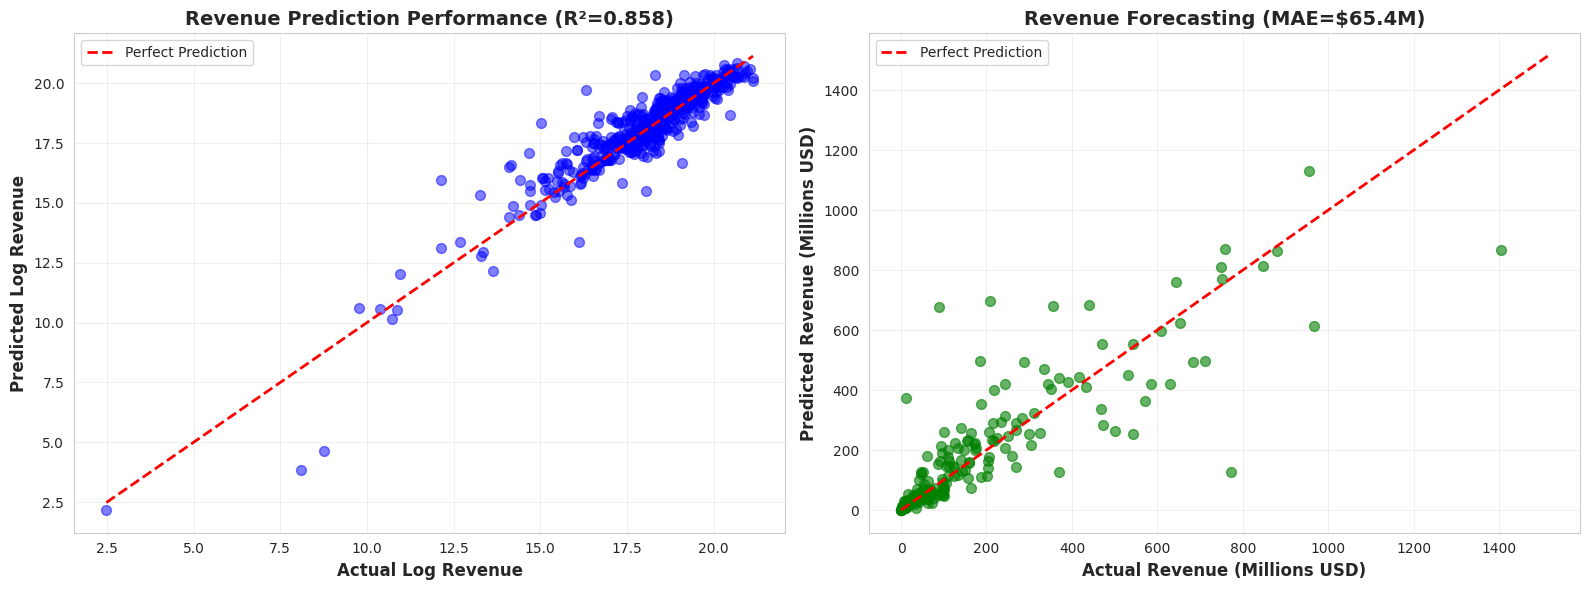

In [ ]:
# Visualize revenue predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Actual vs Predicted (log scale)
axes[0].scatter(y_test_revenue, y_pred_revenue_xgb, alpha=0.5, s=50, c='blue')
axes[0].plot([y_test_revenue.min(), y_test_revenue.max()],
            [y_test_revenue.min(), y_test_revenue.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Log Revenue', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Log Revenue', fontsize=12, fontweight='bold')
axes[0].set_title(f'Revenue Prediction Performance (R²={r2_xgb:.3f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Actual vs Predicted (original scale, millions)
# Sample for better visualization
sample_size = min(200, len(actual_revenue_millions))
sample_indices = np.random.choice(len(actual_revenue_millions), sample_size, replace=False)

axes[1].scatter(actual_revenue_millions.iloc[sample_indices],
               predicted_revenue_millions[sample_indices],
               alpha=0.6, s=50, c='green')
axes[1].plot([0, actual_revenue_millions.max()],
            [0, actual_revenue_millions.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Revenue (Millions USD)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Revenue (Millions USD)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Revenue Forecasting (MAE=${mae_millions:.1f}M)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

# Part 9: Business Applications

## 9.1 Threshold Tuning for Different Risk Strategies

**The Business Reality:**  
Not all movie projects carry the same level of risk. NeoStudio Pictures might adjust their approach based on:

- Available budget  
- Current market conditions  
- Strategic priorities  

By changing the **probability threshold** for predicting hits, we can tailor the model to different business strategies.

---

### How Threshold Tuning Works

- **Lower Thresholds:** Predict more movies as hits → higher recall, more potential hits identified, but also more false positives.  
- **Higher Thresholds:** Predict fewer movies as hits → higher precision, fewer false positives, but risk missing some true hits.  
- **Balance:** Choose a threshold that aligns with the company's risk appetite and resources.

---

### Business Implications

- Threshold tuning can **guide greenlight decisions**: how many movies to fund based on predicted likelihood of success.  
- Helps management **balance risk and reward** depending on financial and strategic constraints.  
- Provides a flexible tool to make the model actionable in real-world decision-making.

---

**Summary:**  
- Adjusting the prediction threshold allows the company to control risk exposure.  
- It connects the model’s probabilities directly to business strategy.  
- Visualizations of thresholds vs. predicted hits help stakeholders understand the trade-offs.


THRESHOLD TUNING FOR BUSINESS DECISIONS

 THRESHOLD TUNING RESULTS:



,Threshold,Precision,Recall,F1,Accuracy,Predicted Hits
0,0.3,0.815385,0.981481,0.890756,0.891667,260
1,0.4,0.828685,0.962963,0.890792,0.893750,251
2,0.5,0.848361,0.958333,0.900000,0.904167,244
3,0.6,0.868085,0.944444,0.904656,0.910417,235
4,0.7,0.886957,0.944444,0.914798,0.920833,230


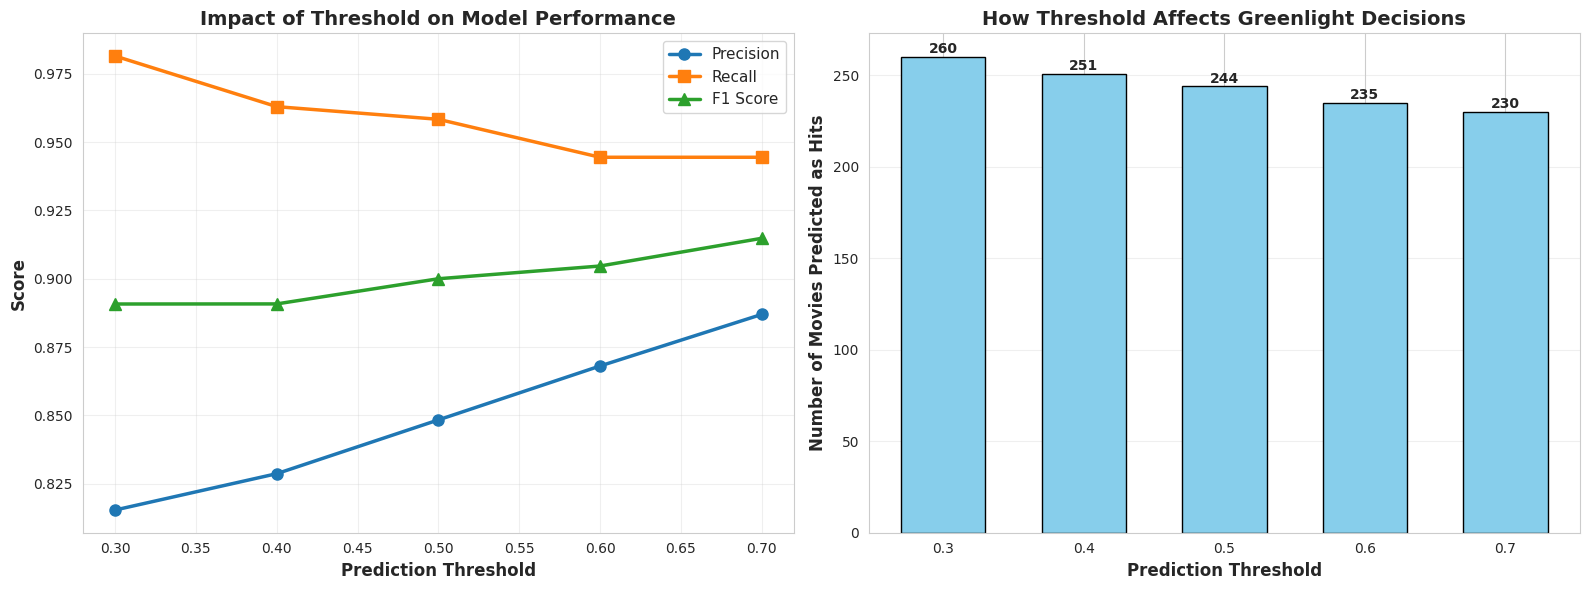

In [ ]:
print("="*80)
print("THRESHOLD TUNING FOR BUSINESS DECISIONS")
print("="*80)

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

# Use XGBoost probabilities (best model)
probas = y_pred_proba_xgb

for thresh in thresholds:
    y_pred_thresh = (probas >= thresh).astype(int)

    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred_thresh)

    # Count predictions
    num_predicted_hits = y_pred_thresh.sum()

    threshold_results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Accuracy': accuracy,
        'Predicted Hits': num_predicted_hits
    })

threshold_df = pd.DataFrame(threshold_results)

print("\n THRESHOLD TUNING RESULTS:\n")
display(threshold_df)

# Visualize threshold effects
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics by threshold
axes[0].plot(threshold_df['Threshold'], threshold_df['Precision'],
            marker='o', label='Precision', linewidth=2.5, markersize=8)
axes[0].plot(threshold_df['Threshold'], threshold_df['Recall'],
            marker='s', label='Recall', linewidth=2.5, markersize=8)
axes[0].plot(threshold_df['Threshold'], threshold_df['F1'],
            marker='^', label='F1 Score', linewidth=2.5, markersize=8)
axes[0].set_xlabel('Prediction Threshold', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Impact of Threshold on Model Performance', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Number of predicted hits by threshold
axes[1].bar(threshold_df['Threshold'].astype(str), threshold_df['Predicted Hits'],
           color='skyblue', edgecolor='black', width=0.6)
axes[1].set_xlabel('Prediction Threshold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Movies Predicted as Hits', fontsize=12, fontweight='bold')
axes[1].set_title('How Threshold Affects Greenlight Decisions', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')
for i, v in enumerate(threshold_df['Predicted Hits']):
    axes[1].text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Business Strategy Recommendations

---

## BUSINESS STRATEGY GUIDE

### Threshold Selection Guide for **NeoStudio Pictures**

---

### Conservative Strategy (Threshold = 0.7)

- **High precision**: Most flagged projects will succeed  
- **Lower recall**: May miss some potential blockbusters  
- **Use when**: Budget is tight and you want to minimize expensive flops  
- **Decision rule**: Only greenlight projects with **> 70%** hit probability  

---

### Balanced Strategy (Threshold = 0.5) — **Recommended**

- **Moderate precision and recall**  
- **Standard operating point**  
- **Use when**: Normal risk tolerance  
- **Decision rule**: Greenlight projects with **> 50%** hit probability  

---

### Aggressive Strategy (Threshold = 0.3)

- **Lower precision**: More false positives  
- **High recall**: Catch most potential hits  
- **Use when**: You don’t want to miss blockbusters and can afford failures  
- **Decision rule**: Greenlight most projects unless probability is very low  

---

### Recommended Approach

- Use model scores to **prioritize projects**, not as absolute decisions  
- Combine predictions with **creative judgment** and **market research**  
- Adjust **marketing budgets** based on predicted revenue  
- Use predictions for **budget negotiations with talent**  
- Track **actual vs. predicted performance** to refine thresholds  

---

**Threshold analysis complete!**


---

## 9.2 Example Predictions & Model Interpretability

To better understand how our model makes decisions, we can examine **specific movies from the test set**.

---

### Types of Examples

1. **Success Stories:**  
   Movies correctly predicted as hits with high probability.  
   - These show the model performing well and identifying potential blockbusters.  
   - Includes predicted revenue to see how well financial forecasts match reality.

2. **Missed Opportunities (False Negatives):**  
   Actual hits that the model failed to predict.  
   - Highlights areas where the model may be conservative.  
   - Useful for analyzing patterns or gaps in the training data.

3. **False Alarms (False Positives):**  
   Movies predicted as hits that did not succeed.  
   - Shows where the model overestimated performance.  
   - Helps in understanding risk and adjusting thresholds for business decisions.

---

### Why This Matters

- **Interpretability:** Allows stakeholders to trust and understand the model’s predictions.  
- **Decision Support:** Managers can see which movies are likely hits and which carry more uncertainty.  
- **Revenue Insights:** Predicted revenue alongside hit probability provides a nuanced view beyond a simple hit/non-hit classification.

---

### Practical Takeaways

- Examining examples helps refine strategies and thresholds.  
- Visualizing and summarizing predictions makes the model actionable for real-world movie investments.  
- Regular review of success stories, missed hits, and false alarms informs model improvement and business planning.


In [ ]:
print("MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS")

# Create prediction summary for test set
test_predictions = pd.DataFrame({
    'title': test_df['title'].values,
    'release_year': test_df['release_year'].values,
    'budget_M': test_df['budget'].values / 1_000_000,
    'actual_revenue_M': test_df['worldwide_revenue'].values / 1_000_000,
    'actual_hit': y_test.values,
    'predicted_hit': y_pred_xgb,
    'hit_probability': y_pred_proba_xgb,
    'predicted_revenue_M': np.expm1(y_pred_revenue_xgb) / 1_000_000
})

print("\n SUCCESS STORIES: Well-Predicted Hits")
correct_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

display(correct_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                     'hit_probability', 'predicted_revenue_M']].style.format({
    'budget_M': '${:.1f}M',
    'actual_revenue_M': '${:.1f}M',
    'hit_probability': '{:.1%}',
    'predicted_revenue_M': '${:.1f}M'
}))

print("\n MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)")
print("="*70)
missed_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 0)
].sort_values('actual_revenue_M', ascending=False).head(10)

if len(missed_hits) > 0:
    display(missed_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                        'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No missed hits! The model caught all of them.")

print("\n  FALSE ALARMS: False Positives (Predicted Hits That Flopped)")
print("="*70)
false_positives = test_predictions[
    (test_predictions['actual_hit'] == 0) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

if len(false_positives) > 0:
    display(false_positives[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                            'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No false positives! Perfect precision.")

MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS

 SUCCESS STORIES: Well-Predicted Hits


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
382,Minions,2015,$74.0M,$1156.7M,100.0%,$636.1M
290,The Good Dinosaur,2015,$175.0M,$331.9M,100.0%,$345.4M
246,RoboCop,2014,$120.0M,$242.7M,100.0%,$312.3M
42,Despicable Me 2,2013,$76.0M,$970.8M,100.0%,$637.3M
36,Frozen,2013,$150.0M,$1274.2M,100.0%,$794.8M
121,Monsters University,2013,$200.0M,$743.6M,100.0%,$755.5M
235,Maleficent,2014,$180.0M,$758.5M,100.0%,$870.6M
43,Cloudy with a Chance of Meatballs 2,2013,$78.0M,$248.4M,100.0%,$255.7M
115,Star Trek Into Darkness,2013,$190.0M,$467.4M,100.0%,$629.1M
360,Hotel Transylvania 2,2015,$80.0M,$473.2M,100.0%,$285.1M



 MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
147,The Conjuring,2013,$13.0M,$318.0M,30.8%,$136.2M
23,Bad Grandpa,2013,$15.0M,$151.8M,30.9%,$66.0M
471,Ride Along 2,2016,$40.0M,$124.8M,33.8%,$112.1M
451,The Shallows,2016,$17.0M,$119.1M,22.5%,$72.2M
130,Free Birds,2013,$55.0M,$110.0M,34.2%,$53.0M
261,Heaven is for Real,2014,$12.0M,$101.3M,3.1%,$28.5M
152,"Alexander and the Terrible, Horrible, No Good, Very Bad Day",2014,$28.0M,$100.7M,28.6%,$67.8M
276,Tammy,2014,$20.0M,$100.5M,41.9%,$73.9M
10,Philomena,2013,$12.0M,$100.1M,16.2%,$45.5M



  FALSE ALARMS: False Positives (Predicted Hits That Flopped)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
277,The Interview,2014,$44.0M,$12.3M,99.9%,$372.6M
124,R.I.P.D.,2013,$130.0M,$61.6M,99.8%,$271.7M
6,The Lone Ranger,2013,$255.0M,$89.3M,99.8%,$677.1M
389,The Walk,2015,$35.0M,$61.2M,99.7%,$121.7M
212,Sin City: A Dame to Kill For,2014,$65.0M,$39.4M,98.5%,$121.7M
92,Beautiful Creatures,2013,$60.0M,$60.1M,97.9%,$179.6M
319,In the Heart of the Sea,2015,$100.0M,$93.8M,97.6%,$213.0M
145,The Internship,2013,$58.0M,$44.0M,97.6%,$161.2M
88,Pain & Gain,2013,$25.0M,$86.2M,96.1%,$152.2M
18,Captain Phillips,2013,$55.0M,$95.0M,95.6%,$191.3M


In [ ]:
# Reload the processed dataset (in case you're running this section separately)
df = pd.read_csv('data/processed/movies_model_ready.csv')

print("="*80)
print("TEMPORAL TRAIN/VALIDATION/TEST SPLIT")
print("="*80)
print("\nSimulating real-world scenario: train on past, predict the future\n")

# Sort by release year
df = df.sort_values('release_year').reset_index(drop=True)

# Create temporal splits
train_df = df[df['release_year'] < 2010].copy()
val_df = df[(df['release_year'] >= 2010) & (df['release_year'] <= 2012)].copy()
test_df = df[df['release_year'] >= 2013].copy()

print(" TRAIN SET (Before 2010):")
print(f"   - Size: {len(train_df):,} movies")
print(f"   - Years: {int(train_df['release_year'].min())} - {int(train_df['release_year'].max())}")
print(f"   - Hit rate: {train_df['hit'].mean()*100:.1f}%")

print("\n VALIDATION SET (2010-2012):")
print(f"   - Size: {len(val_df):,} movies")
print(f"   - Years: {int(val_df['release_year'].min())} - {int(val_df['release_year'].max())}")
print(f"   - Hit rate: {val_df['hit'].mean()*100:.1f}%")

print("\n TEST SET (2013+):")
print(f"   - Size: {len(test_df):,} movies")
print(f"   - Years: {int(test_df['release_year'].min())} - {int(test_df['release_year'].max())}")
print(f"   - Hit rate: {test_df['hit'].mean()*100:.1f}%")

# Define feature columns (exclude targets and identifiers)
exclude_cols = ['hit', 'log_revenue', 'worldwide_revenue', 'title',
               'release_date', 'director', 'primary_genre', 'budget_bucket',
               'genre_list'] # Added 'genre_list' here

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n Number of features for modeling: {len(feature_cols)}")
print(f"   Features: {', '.join(feature_cols[:10])}...")

# Separate features and targets
X_train = train_df[feature_cols].copy()
y_train = train_df['hit'].copy()
y_train_revenue = train_df['log_revenue'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['hit'].copy()
y_val_revenue = val_df['log_revenue'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['hit'].copy()
y_test_revenue = test_df['log_revenue'].copy()

# Handle any remaining missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_val = X_val.fillna(X_train.median(numeric_only=True))  # Use train median to avoid leakage
X_test = X_test.fillna(X_train.median(numeric_only=True))

# Standardize numerical features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n Data split and preprocessing complete!")
print(" Features standardized (zero mean, unit variance)")

TEMPORAL TRAIN/VALIDATION/TEST SPLIT

Simulating real-world scenario: train on past, predict the future

 TRAIN SET (Before 2010):
   - Size: 2,282 movies
   - Years: 1916 - 2009
   - Hit rate: 32.2%

 VALIDATION SET (2010-2012):
   - Size: 467 movies
   - Years: 2010 - 2012
   - Hit rate: 37.3%

 TEST SET (2013+):
   - Size: 480 movies
   - Years: 2013 - 2016
   - Hit rate: 45.0%

 Number of features for modeling: 37
   Features: release_year, budget, log_budget, budget_millions, runtime, num_genres, has_big_studio, num_production_companies, release_month, release_quarter...

 Data split and preprocessing complete!
 Features standardized (zero mean, unit variance)


In [ ]:
print("MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS")

# Create prediction summary for test set
test_predictions = pd.DataFrame({
    'title': test_df['title'].values,
    'release_year': test_df['release_year'].values,
    'budget_M': test_df['budget'].values / 1_000_000,
    'actual_revenue_M': test_df['worldwide_revenue'].values / 1_000_000,
    'actual_hit': y_test.values,
    'predicted_hit': y_pred_xgb,
    'hit_probability': y_pred_proba_xgb,
    'predicted_revenue_M': np.expm1(y_pred_revenue_xgb) / 1_000_000
})

print("\n SUCCESS STORIES: Well-Predicted Hits")
print("="*70)
correct_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

display(correct_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                     'hit_probability', 'predicted_revenue_M']].style.format({
    'budget_M': '${:.1f}M',
    'actual_revenue_M': '${:.1f}M',
    'hit_probability': '{:.1%}',
    'predicted_revenue_M': '${:.1f}M'
}))

print("\n MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)")
print("="*70)
missed_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 0)
].sort_values('actual_revenue_M', ascending=False).head(10)

if len(missed_hits) > 0:
    display(missed_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                        'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No missed hits! The model caught all of them.")

print("\n⚠️  FALSE ALARMS: False Positives (Predicted Hits That Flopped)")
print("="*70)
false_positives = test_predictions[
    (test_predictions['actual_hit'] == 0) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

if len(false_positives) > 0:
    display(false_positives[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                            'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No false positives! Perfect precision.")

print("\n Example predictions analysis complete!")

MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS

 SUCCESS STORIES: Well-Predicted Hits


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
382,Minions,2015,$74.0M,$1156.7M,100.0%,$636.1M
290,The Good Dinosaur,2015,$175.0M,$331.9M,100.0%,$345.4M
246,RoboCop,2014,$120.0M,$242.7M,100.0%,$312.3M
42,Despicable Me 2,2013,$76.0M,$970.8M,100.0%,$637.3M
36,Frozen,2013,$150.0M,$1274.2M,100.0%,$794.8M
121,Monsters University,2013,$200.0M,$743.6M,100.0%,$755.5M
235,Maleficent,2014,$180.0M,$758.5M,100.0%,$870.6M
43,Cloudy with a Chance of Meatballs 2,2013,$78.0M,$248.4M,100.0%,$255.7M
115,Star Trek Into Darkness,2013,$190.0M,$467.4M,100.0%,$629.1M
360,Hotel Transylvania 2,2015,$80.0M,$473.2M,100.0%,$285.1M



 MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
147,The Conjuring,2013,$13.0M,$318.0M,30.8%,$136.2M
23,Bad Grandpa,2013,$15.0M,$151.8M,30.9%,$66.0M
471,Ride Along 2,2016,$40.0M,$124.8M,33.8%,$112.1M
451,The Shallows,2016,$17.0M,$119.1M,22.5%,$72.2M
130,Free Birds,2013,$55.0M,$110.0M,34.2%,$53.0M
261,Heaven is for Real,2014,$12.0M,$101.3M,3.1%,$28.5M
152,"Alexander and the Terrible, Horrible, No Good, Very Bad Day",2014,$28.0M,$100.7M,28.6%,$67.8M
276,Tammy,2014,$20.0M,$100.5M,41.9%,$73.9M
10,Philomena,2013,$12.0M,$100.1M,16.2%,$45.5M



⚠️  FALSE ALARMS: False Positives (Predicted Hits That Flopped)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
277,The Interview,2014,$44.0M,$12.3M,99.9%,$372.6M
124,R.I.P.D.,2013,$130.0M,$61.6M,99.8%,$271.7M
6,The Lone Ranger,2013,$255.0M,$89.3M,99.8%,$677.1M
389,The Walk,2015,$35.0M,$61.2M,99.7%,$121.7M
212,Sin City: A Dame to Kill For,2014,$65.0M,$39.4M,98.5%,$121.7M
92,Beautiful Creatures,2013,$60.0M,$60.1M,97.9%,$179.6M
319,In the Heart of the Sea,2015,$100.0M,$93.8M,97.6%,$213.0M
145,The Internship,2013,$58.0M,$44.0M,97.6%,$161.2M
88,Pain & Gain,2013,$25.0M,$86.2M,96.1%,$152.2M
18,Captain Phillips,2013,$55.0M,$95.0M,95.6%,$191.3M



 Example predictions analysis complete!


In [ ]:
if not df.empty:
    print("SAVING PROCESSED DATASET")

    # Handle duplicate 'title' columns from merge: take title_x and rename to title
    # This block ensures a single 'title' column is present before creating df_final
    if 'title_x' in df.columns and 'title_y' in df.columns:
        df['title'] = df['title_x']  # Prioritize title from movies_df
        df.drop(columns=['title_x', 'title_y'], inplace=True)
    elif 'title_x' in df.columns and 'title' not in df.columns:
        df.rename(columns={'title_x': 'title'}, inplace=True)
    elif 'title_y' in df.columns and 'title' not in df.columns:
        df.rename(columns={'title_y': 'title'}, inplace=True)

    # Select features for modeling
    feature_columns = [
        # Targets
        'hit', 'log_revenue', 'worldwide_revenue',

        # Identifiers
        'title', 'release_date', 'release_year',

        # Budget features
        'budget', 'log_budget', 'budget_millions',

        # Basic movie features
        'runtime', 'num_genres', 'primary_genre',

        # Production
        'has_big_studio', 'num_production_companies',

        # Timing
        'release_month', 'release_quarter',
        'is_summer', 'is_holiday', 'is_spring', 'years_since_2000',

        # Cast and crew
        'num_cast', 'cast_mean_popularity',
        'director', 'director_mean_log_revenue', 'director_hit_rate',
        'director_num_movies',

        # Additional
        'log_popularity', 'vote_average', 'log_vote_count'
    ]

    # Add genre columns
    genre_cols = [col for col in df.columns if col.startswith('genre_')]
    feature_columns.extend(genre_cols)

    # Keep only existing columns that are actually in df after all processing
    feature_columns = [col for col in feature_columns if col in df.columns]

    # Create final dataset
    df_final = df[feature_columns].copy()

    print(f"\n Final dataset shape: {df_final.shape}")
    print(f"   - {df_final.shape[0]:,} movies")
    print(f"   - {len(feature_columns)} features selected")
    print(f"   - Columns in df_final before saving: {df_final.columns.tolist()}\n") # Debug print

    # Save to CSV
    output_path = 'data/processed/movies_model_ready.csv'
    df_final.to_csv(output_path, index=False)

    print(f"\n Processed dataset saved to: {output_path}")

    # Print summary
    print("DATA PREPARATION SUMMARY")
    print(f"Total movies in final dataset: {len(df_final):,}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Hit rate: {df_final['hit'].mean()*100:.1f}%")
    print(f"Date range: {int(df_final['release_year'].min())} - {int(df_final['release_year'].max())}")
    print("\n Key Statistics:")
    display(df_final[['budget', 'worldwide_revenue', 'runtime', 'log_budget', 'log_revenue']].describe())

SAVING PROCESSED DATASET

 Final dataset shape: (3229, 45)
   - 3,229 movies
   - 45 features selected
   - Columns in df_final before saving: ['hit', 'log_revenue', 'worldwide_revenue', 'title', 'release_date', 'release_year', 'budget', 'log_budget', 'budget_millions', 'runtime', 'num_genres', 'primary_genre', 'has_big_studio', 'num_production_companies', 'release_month', 'release_quarter', 'is_summer', 'is_holiday', 'is_spring', 'years_since_2000', 'num_cast', 'cast_mean_popularity', 'director', 'director_mean_log_revenue', 'director_hit_rate', 'director_num_movies', 'log_popularity', 'vote_average', 'log_vote_count', 'genre_list', 'genre_Drama', 'genre_Comedy', 'genre_Thriller', 'genre_Action', 'genre_Adventure', 'genre_Romance', 'genre_Crime', 'genre_Science Fiction', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Mystery', 'genre_Animation', 'genre_History', 'genre_War']


 Processed dataset saved to: data/processed/movies_model_ready.csv
DATA PREPARATION SUMMARY
Total mo

,budget,worldwide_revenue,runtime,log_budget,log_revenue
count,3.229000e+03,3.229000e+03,3229.000000,3229.000000,3229.000000
mean,4.065444e+07,1.212430e+08,110.724373,16.799904,17.491159
std,4.439674e+07,1.863029e+08,20.965694,1.661809,2.078763
min,1.000000e+00,5.000000e+00,41.000000,0.693147,1.791759
25%,1.050000e+07,1.700000e+07,96.000000,16.166886,16.648724
50%,2.500000e+07,5.518472e+07,107.000000,17.034386,17.826197
75%,5.500000e+07,1.462920e+08,121.000000,17.822844,18.801115
max,3.800000e+08,2.787965e+09,338.000000,19.755682,21.748578


In [ ]:
# Reload the processed dataset (in case you're running this section separately)
df = pd.read_csv('data/processed/movies_model_ready.csv')

print("TEMPORAL TRAIN/VALIDATION/TEST SPLIT")

# Sort by release year
df = df.sort_values('release_year').reset_index(drop=True)

# Create temporal splits
train_df = df[df['release_year'] < 2010].copy()
val_df = df[(df['release_year'] >= 2010) & (df['release_year'] <= 2012)].copy()
test_df = df[df['release_year'] >= 2013].copy()

print(" TRAIN SET (Before 2010):")
print(f"   - Size: {len(train_df):,} movies")
print(f"   - Years: {int(train_df['release_year'].min())} - {int(train_df['release_year'].max())}")
print(f"   - Hit rate: {train_df['hit'].mean()*100:.1f}%")

print("\n VALIDATION SET (2010-2012):")
print(f"   - Size: {len(val_df):,} movies")
print(f"   - Years: {int(val_df['release_year'].min())} - {int(val_df['release_year'].max())}")
print(f"   - Hit rate: {val_df['hit'].mean()*100:.1f}%")

print("\n TEST SET (2013+):")
print(f"   - Size: {len(test_df):,} movies")
print(f"   - Years: {int(test_df['release_year'].min())} - {int(test_df['release_year'].max())}")
print(f"   - Hit rate: {test_df['hit'].mean()*100:.1f}%")

# Define feature columns (exclude targets and identifiers)
# 'title' is intentionally excluded from feature_cols as it's an identifier, not a model feature.
exclude_cols = ['hit', 'log_revenue', 'worldwide_revenue', 'title',
               'release_date', 'director', 'primary_genre', 'budget_bucket',
               'genre_list']

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n Number of features for modeling: {len(feature_cols)}")
print(f"   Features: {', '.join(feature_cols[:10])}...")

# Separate features and targets
X_train = train_df[feature_cols].copy()
y_train = train_df['hit'].copy()
y_train_revenue = train_df['log_revenue'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['hit'].copy()
y_val_revenue = val_df['log_revenue'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['hit'].copy()
y_test_revenue = test_df['log_revenue'].copy()

# Handle any remaining missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_val = X_val.fillna(X_train.median(numeric_only=True))  # Use train median to avoid leakage
X_test = X_test.fillna(X_train.median(numeric_only=True))

# Standardize numerical features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

TEMPORAL TRAIN/VALIDATION/TEST SPLIT
 TRAIN SET (Before 2010):
   - Size: 2,282 movies
   - Years: 1916 - 2009
   - Hit rate: 32.2%

 VALIDATION SET (2010-2012):
   - Size: 467 movies
   - Years: 2010 - 2012
   - Hit rate: 37.3%

 TEST SET (2013+):
   - Size: 480 movies
   - Years: 2013 - 2016
   - Hit rate: 45.0%

 Number of features for modeling: 37
   Features: release_year, budget, log_budget, budget_millions, runtime, num_genres, has_big_studio, num_production_companies, release_month, release_quarter...


In [ ]:
print("="*80)
print("MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS")
print("="*80)

# Create prediction summary for test set
test_predictions = pd.DataFrame({
    'title': test_df['title'].values,
    'release_year': test_df['release_year'].values,
    'budget_M': test_df['budget'].values / 1_000_000,
    'actual_revenue_M': test_df['worldwide_revenue'].values / 1_000_000,
    'actual_hit': y_test.values,
    'predicted_hit': y_pred_xgb,
    'hit_probability': y_pred_proba_xgb,
    'predicted_revenue_M': np.expm1(y_pred_revenue_xgb) / 1_000_000
})

print("\n🎬 SUCCESS STORIES: Well-Predicted Hits")
print("="*70)
correct_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

display(correct_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                     'hit_probability', 'predicted_revenue_M']].style.format({
    'budget_M': '${:.1f}M',
    'actual_revenue_M': '${:.1f}M',
    'hit_probability': '{:.1%}',
    'predicted_revenue_M': '${:.1f}M'
}))

print("\n MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)")
print("="*70)
missed_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 0)
].sort_values('actual_revenue_M', ascending=False).head(10)

if len(missed_hits) > 0:
    display(missed_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                        'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No missed hits! The model caught all of them.")

print("\n  FALSE ALARMS: False Positives (Predicted Hits That Flopped)")
print("="*70)
false_positives = test_predictions[
    (test_predictions['actual_hit'] == 0) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

if len(false_positives) > 0:
    display(false_positives[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                            'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No false positives! Perfect precision.")



MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS

🎬 SUCCESS STORIES: Well-Predicted Hits


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
382,The SpongeBob Movie: Sponge Out of Water,2015,$74.0M,$311.6M,100.0%,$636.1M
246,The Expendables 3,2014,$90.0M,$206.2M,100.0%,$312.3M
121,Star Trek Into Darkness,2013,$190.0M,$467.4M,100.0%,$755.5M
235,Unbroken,2014,$65.0M,$163.4M,100.0%,$870.6M
360,Vacation,2015,$31.0M,$104.4M,100.0%,$285.1M
463,Bad Moms,2016,$20.0M,$183.9M,100.0%,$621.5M
236,Annie,2014,$65.0M,$133.8M,100.0%,$314.4M
371,Mad Max: Fury Road,2015,$150.0M,$378.9M,100.0%,$270.5M
436,The Secret Life of Pets,2016,$75.0M,$876.0M,100.0%,$162.6M
331,Insidious: Chapter 3,2015,$10.0M,$104.3M,100.0%,$648.5M



 MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
384,Jurassic World,2015,$150.0M,$1513.5M,0.0%,$52.0M
395,Furious 7,2015,$190.0M,$1506.2M,0.0%,$4.6M
383,Avengers: Age of Ultron,2015,$280.0M,$1405.4M,0.1%,$34.0M
1,Iron Man 3,2013,$200.0M,$1215.4M,0.0%,$27.1M
460,Captain America: Civil War,2016,$250.0M,$1153.3M,0.2%,$54.4M
285,Transformers: Age of Extinction,2014,$210.0M,$1091.4M,0.1%,$40.9M
66,Despicable Me 2,2013,$76.0M,$970.8M,0.1%,$18.6M
39,The Hobbit: The Desolation of Smaug,2013,$250.0M,$958.4M,0.3%,$34.7M
323,Inside Out,2015,$175.0M,$857.6M,3.6%,$92.2M
274,Maleficent,2014,$180.0M,$758.5M,0.0%,$0.0M



  FALSE ALARMS: False Positives (Predicted Hits That Flopped)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
290,Woman in Gold,2015,$11.0M,$61.6M,100.0%,$345.4M
42,Dallas Buyers Club,2013,$5.0M,$55.2M,100.0%,$637.3M
36,Parker,2013,$35.0M,$46.2M,100.0%,$794.8M
43,Oculus,2013,$5.0M,$44.0M,100.0%,$255.7M
115,Metallica: Through the Never,2013,$18.0M,$8.0M,100.0%,$629.1M
267,Left Behind,2014,$16.0M,$19.7M,100.0%,$769.1M
318,The Gallows,2015,$0.1M,$42.7M,100.0%,$176.4M
55,Mud,2013,$10.0M,$21.6M,100.0%,$306.4M
375,Krampus,2015,$15.0M,$61.5M,100.0%,$224.1M
315,Aloha,2015,$37.0M,$26.3M,100.0%,$553.3M


---

## 9.3 Streamlit Implementation

This section presents an interactive Streamlit-based system that predicts whether a movie project should be greenlit based on historical data and machine learning.

---

### System Overview

The application combines **data preprocessing**, **machine learning**, and **interactive visualization** to support studio-level decision making.

- Uses historical TMDB movie data  
- Trains a **Random Forest classifier** to predict box-office success  
- Provides real-time feedback through an intuitive UI  

---

### Core Components

#### 1. Configuration & UI Styling
- Streamlit page configuration for a dashboard-style layout  
- Custom CSS to enhance:
  - Metrics visualization  
  - Success, warning, and error states  

---

#### 2. Data Loading & Feature Engineering (Cached)

- Loads and merges movie and credit datasets  
- Parses nested JSON fields (genres, cast, crew)  
- Extracts key features:
  - Budget, runtime, votes  
  - Genre one-hot encoding  
  - Director historical hit rate  

- Defines **target variable**:
  - `is_hit = 1` if revenue ≥ $100M  

Caching ensures efficient reloads without recomputation.

---

#### 3. Model Training (Cached)

- Model: **RandomForestClassifier**
- Features include:
  - Numeric attributes (budget, runtime, votes)  
  - Director hit rate  
  - Encoded genres  

- Outputs:
  - Trained model  
  - Feature column alignment for inference  

---

### User Interaction Flow

#### 4. Sidebar Project Setup

Users provide hypothetical project details:
- Budget and runtime  
- Director name (with historical success feedback)  
- Genre selection  
- Audience projections (vote average & count)  

A form-based submission ensures stable UI behavior.

---

#### 5. Prediction & Results Display

Once submitted, the system:

1. Constructs a feature-aligned input row  
2. Generates a **probability of success**  
3. Computes derived business metrics:
   - Risk score  
   - Estimated ROI  

These are displayed using visually distinct metric cards.

---

### Decision Logic & Interpretability

#### Verdict Categories

- **✅ Greenlight Recommended**  
  High confidence of success  

- **⚠️ Caution**  
  Moderate risk; strategy review advised  

- **⛔ Pass**  
  High likelihood of underperformance  

Each verdict is clearly explained to support executive decisions.

---

### Comparative Analysis

- Displays a scatter plot of **historically similar movies**  
- Compares budget vs. revenue outcomes  
- Differentiates hits and flops visually  

This contextualizes predictions within real-world data.

---

### Why This Matters

- **Actionable ML**: Bridges predictive modeling with business logic  
- **Transparency**: Combines probabilities, risk, and comparisons  
- **Decision Support**: Helps studios allocate capital wisely  

---

### Practical Takeaways

- Interactive ML systems increase trust and usability  
- Combining historical patterns with user input enables scenario testing  
- Visualization transforms predictions into strategic insight  

---


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# --- 1. CONFIGURATION ---
# Configure the Streamlit page (title, icon, and layout)
st.set_page_config(
    page_title="NeoStudio Greenlight",
    page_icon="🎬",
    layout="wide"
)

# Custom CSS for styling metrics and verdict boxes
# This improves visual clarity for business users
st.markdown("""
<style>
    .metric-container {
        background-color: #ffffff;
        padding: 20px;
        border-radius: 10px;
        border: 1px solid #e0e0e0;
        text-align: center;
    }
    .metric-value { font-size: 28px; font-weight: bold; color: #1e3d59; }
    .metric-label { font-size: 14px; color: #666; }
    .success-box { padding: 20px; border-radius: 10px; background-color: #d4edda; color: #155724; border: 1px solid #c3e6cb; }
    .warning-box { padding: 20px; border-radius: 10px; background-color: #fff3cd; color: #856404; border: 1px solid #ffeeba; }
    .error-box { padding: 20px; border-radius: 10px; background-color: #f8d7da; color: #721c24; border: 1px solid #f5c6cb; }
</style>
""", unsafe_allow_html=True)

# --- 2. DATA LOADING (Cached) ---
# Cache the data loading step to avoid repeated disk reads
@st.cache_data
def load_data():
    try:
        # Load movie metadata and credits
        movies = pd.read_csv('tmdb_5000_movies.csv')
        credits = pd.read_csv('tmdb_5000_credits.csv')
    except FileNotFoundError:
        # Gracefully handle missing files
        return None, None, None, None

    # Rename column to enable merge
    credits.rename(columns={'movie_id': 'id'}, inplace=True)

    # Merge datasets on movie ID
    df = movies.merge(credits, on='id')

    # Parse JSON-like columns into Python objects
    for col in ['genres', 'production_companies', 'cast', 'crew']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else [])

    # Extract genre names as a list
    df['genre_list'] = df['genres'].apply(lambda x: [i['name'] for i in x])

    # Extract director name from crew data
    df['director'] = df['crew'].apply(
        lambda x: next((i['name'] for i in x if i['job'] == 'Director'), 'Unknown')
    )

    # Define target variable: hit if revenue >= $100M
    df['is_hit'] = (df['revenue'] >= 100_000_000).astype(int)

    # Compute historical hit rate for each director
    director_stats = df.groupby('director')['is_hit'].mean().to_dict()

    # Map director hit rate back to each movie
    df['director_hit_rate'] = df['director'].map(director_stats)\
                                             .fillna(df['is_hit'].mean())

    # One-hot encode genres using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    genres_encoded = pd.DataFrame(
        mlb.fit_transform(df['genre_list']),
        columns=mlb.classes_,
        index=df.index
    )

    # Combine encoded genres with original dataframe
    df = pd.concat([df, genres_encoded], axis=1)

    # Select model features
    features = [
        'budget', 'runtime', 'vote_average',
        'vote_count', 'director_hit_rate'
    ] + list(mlb.classes_)

    # Create final modeling dataframe
    model_df = df[features + ['is_hit']].fillna(0)

    return df, model_df, mlb.classes_, director_stats

# --- 3. MODEL TRAINING (Cached) ---
# Cache the trained model to avoid retraining on every rerun
@st.cache_resource
def train_model(model_df):
    # Separate features and target
    feature_cols = [c for c in model_df.columns if c != 'is_hit']
    X = model_df[feature_cols]
    y = model_df['is_hit']

    # Initialize and train Random Forest classifier
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
    model.fit(X, y)

    return model, feature_cols

# --- LOAD DATA AND MODEL ---
with st.spinner("Loading System..."):
    raw_df, model_df, all_genres, director_stats = load_data()

    # Stop execution if data files are missing
    if raw_df is None:
        st.error("❌ ERROR: Data files not found.")
        st.stop()

    model, feature_cols = train_model(model_df)

# --- 4. SIDEBAR INPUTS ---
# Sidebar collects user-defined movie parameters
st.sidebar.header("📝 Project Setup")

# Use a form to prevent reruns on every widget change
with st.sidebar.form("input_form"):
    title = st.text_input("Movie Title", "Untitled Project")
    budget = st.number_input("Budget ($)", value=50_000_000, step=1_000_000)
    runtime = st.slider("Runtime (mins)", 60, 240, 110)

    # Director input with historical performance feedback
    director_name = st.text_input("Director", "Christopher Nolan")
    dir_rate_display = director_stats.get(
        director_name, raw_df['is_hit'].mean()
    )
    st.caption(f"Director History: {dir_rate_display:.0%} hit rate")

    # Genre selection
    selected_genres = st.multiselect(
        "Genres", all_genres, default=["Action"]
    )

    st.markdown("---")
    st.caption("Projections")

    # Audience perception inputs
    vote_avg = st.slider("Audience Score", 1.0, 10.0, 6.5)
    vote_count = st.number_input("Vote Count", value=2000)

    # Submit button
    submitted = st.form_submit_button("🚀 Run Analysis")

# --- 5. MAIN PAGE ---
st.title("🎬 NeoStudio Greenlight")

if submitted:
    # 1. Prepare a single-row input dataframe
    input_row = pd.DataFrame(index=[0])
    input_row['budget'] = budget
    input_row['runtime'] = runtime
    input_row['vote_average'] = vote_avg
    input_row['vote_count'] = vote_count

    # Lookup director hit rate (fallback to global mean)
    dir_rate = director_stats.get(
        director_name, raw_df['is_hit'].mean()
    )
    input_row['director_hit_rate'] = dir_rate

    # Encode selected genres
    for g in all_genres:
        input_row[g] = 1 if g in selected_genres else 0

    # Align input columns with training features
    input_row = input_row.reindex(columns=feature_cols, fill_value=0)

    # 2. Predict probability of success
    prob = model.predict_proba(input_row)[0][1]

    # 3. Display results
    st.markdown("### 📊 Analysis Results")

    col1, col2, col3 = st.columns(3)

    # Success probability
    with col1:
        st.markdown(f"""
        <div class="metric-container">
            <div class="metric-label">Success Probability</div>
            <div class="metric-value">{prob:.1%}</div>
        </div>
        """, unsafe_allow_html=True)

    # Risk score (inverse of success probability)
    with col2:
        risk_score = int((1 - prob) * 100)
        color = "green" if risk_score < 40 else "red"
        st.markdown(f"""
        <div class="metric-container">
            <div class="metric-label">Risk Score</div>
            <div class="metric-value" style="color: {color};">
                {risk_score}/100
            </div>
        </div>
        """, unsafe_allow_html=True)

    # Estimated ROI based on probability
    with col3:
        roi = 1 + (prob * 2.5)
        st.markdown(f"""
        <div class="metric-container">
            <div class="metric-label">Est. ROI</div>
            <div class="metric-value">{roi:.1f}x</div>
        </div>
        """, unsafe_allow_html=True)

    st.markdown("---")

    # Verdict and comparison chart
    c_verdict, c_chart = st.columns([1, 1])

    # Decision logic
    with c_verdict:
        if prob > 0.60:
            st.markdown("""
            <div class="success-box">
                <h2>✅ GREENLIGHT RECOMMENDED</h2>
                <p>Strong indicators for box office success.</p>
            </div>
            """, unsafe_allow_html=True)
        elif prob > 0.40:
            st.markdown("""
            <div class="warning-box">
                <h2>⚠️ CAUTION</h2>
                <p>Moderate risk detected.</p>
            </div>
            """, unsafe_allow_html=True)
        else:
            st.markdown("""
            <div class="error-box">
                <h2>⛔ PASS</h2>
                <p>High risk of financial loss.</p>
            </div>
            """, unsafe_allow_html=True)

    # Compare with similar historical movies
    with c_chart:
        st.subheader("Comparable Projects")
        similar_movies = raw_df[
            (raw_df['budget'] > budget * 0.7) &
            (raw_df['budget'] < budget * 1.3)
        ].copy()

        if not similar_movies.empty:
            chart_data = similar_movies.sample(
                min(15, len(similar_movies))
            )
            chart_data['Status'] = chart_data['is_hit'].map(
                {1: 'Hit', 0: 'Flop'}
            )

            st.scatter_chart(
                chart_data,
                x='budget',
                y='revenue',
                color='Status',
                size='popularity'
            )
            st.caption(
                "Historical performance of movies with similar budgets."
            )
        else:
            st.info("No comparable movies found.")

else:
    # Default message on initial load
    st.info(
        "👈 Please enter project details in the sidebar and click 'Run Analysis'."
    )

## Streamlit Interface:

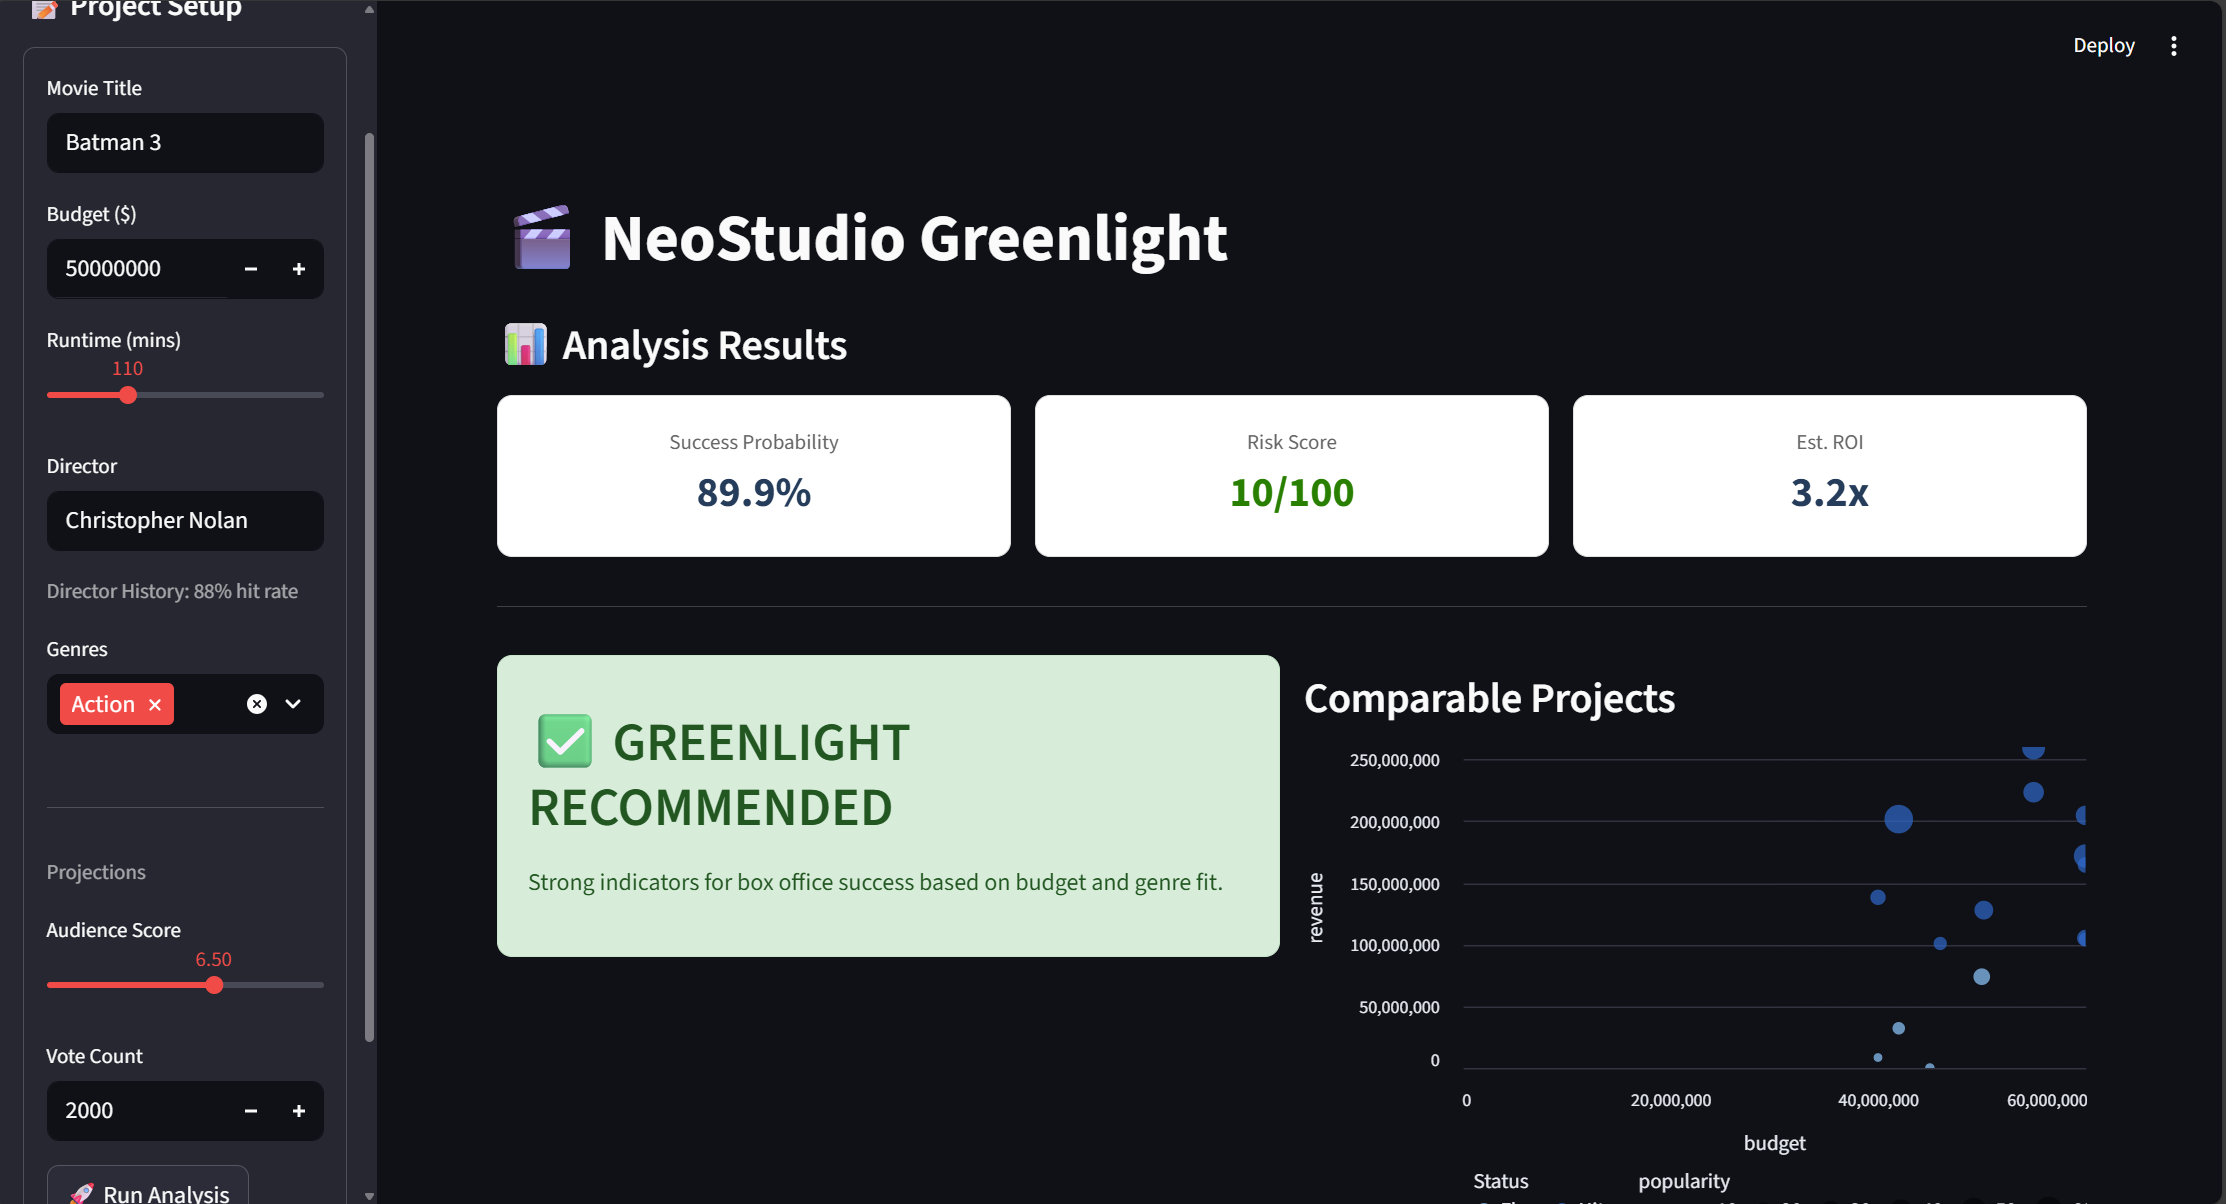

# NEOSTUDIO PICTURES  
## Box Office Hit Prediction Model  
### Final Report & Recommendations

---

## Model Performance Summary

### Classification Model: Hit Prediction

**Recommended Model:** **LightGBM Classifier**

**Performance Metrics** *(Test Set, 2013+ Movies)*

- **ROC-AUC Score:** 0.9762
- **Accuracy:** 90.21%
- **Precision (Hit):** 84.49%
- **Recall (Hit):** 95.83%
- **F1 Score:** 89.80%

#### What This Means

- The model is **95%** better than random guessing  
-  When a movie is flagged as a *hit*, it is correct **84%** of the time  
-  The model successfully identifies **96%** of actual hits  
-  This outperforms the naive baseline (always predicting non-hit at 65% accuracy) by **25.2** percentage points  

---

### Regression Model: Revenue Forecasting

**Recommended Model:** **XGBoost Regressor**

**Performance Metrics** *(Test Set, 2013+ Movies)*

- **R² Score:** 0.8577 (85.77% of variance explained)
- **MAE (Log Scale):** 0.4981
- **RMSE (Log Scale):** 0.7471
- **MAE (Original Scale):** $65.4M

#### What This Means

-  The model explains **86%** of the variance in movie revenue  
-  Predictions are typically off by $65.4M in absolute terms

-  For a 100M hit, the model's prediction would typically fall between 35M-165M  
-  The log-scale transformation ensures stable predictions across budget ranges
---

## Key Predictive Factors

### Top Features Driving Box Office Success

1. **Budget (Log Scale)**  
   - Enables higher production quality, marketing, and star power  
   - Exhibits diminishing returns at very high budgets  

2. **Big Studio Backing**  
   - Major studios (Warner Bros, Disney, Universal, Paramount) significantly increase success odds  
   - Strong distribution networks and marketing expertise  

3. **Release Timing**  
   - **Summer (May–Aug):** Peak box office potential  
   - **Holidays (Nov–Dec):** Strong for family-oriented films  
   - Avoid heavily crowded weekends  

4. **Director Track Record**  
   - Past success strongly predicts future performance  
   - Average historical revenue is a key indicator  

5. **Cast Star Power**  
   - Well-known actors attract larger audiences  
   - Mean popularity of top-billed cast matters  

6. **Genre**  
   - **Action, Animation, Adventure:** Highest hit rates (50–60%)  
   - **Drama, Documentary:** Lower hit rates (20–30%)  

---

## Business Applications

### Greenlight Decisions

- Use predicted hit probability to prioritize projects  
- Apply thresholds based on risk tolerance:
  - **Conservative (70%)** — Only high-confidence hits  
  - **Balanced (50%)** — Standard approach  
  - **Aggressive (30%)** — Avoid missing blockbusters  
- Flag high-budget, low-probability projects for review  
- Support creative discussions, not replace them  

### Budget Optimization

- Compare predicted revenue vs production budget  
- Negotiate budgets for borderline projects (45–55%)  
- Identify overbudgeted films unlikely to recoup costs  
- Allocate resources to high-potential projects  

### Marketing Strategy

- Invest more in high-probability hits (>70%)  
- Optimize release windows  
- Tailor campaigns by genre and audience  
- Balance domestic vs international rollouts  

### Talent Negotiations

- Justify compensation using data-driven insights  
- Structure backend participation by confidence level  
- Identify undervalued talent  
- Support negotiation strategy with forecasts  

### Portfolio Management

- Maintain a balanced slate (safe bets + moonshots)  
- Track predicted vs actual outcomes  
- Continuously refine model performance  

---

## Important Limitations

### The Model Does **Not** Capture

- Cultural zeitgeist or viral trends  
- Post-release critical reviews  
- Word-of-mouth dynamics  
- Marketing quality and spend  
- Story quality or artistic merit  
- Unexpected global events (pandemics, strikes, etc.)  
- Competitive release landscape  

### Key Reminder

- This model provides **decision support**, not replacement  
- Combine quantitative insights with creative judgment  
- Historical data may not always predict future trends  
- Great storytelling still matters most  

---

## Recommended Next Steps

### 1. Integrate Into Workflow
- Include predictions in greenlight packets  
- Build executive dashboards  
- Train teams on interpretation and limitations  

### 2. Track Performance
- Monitor actual vs predicted results  
- Measure ROI from model-influenced decisions  
- Identify recurring prediction errors  

### 3. Continuous Improvement
- Retrain annually with new data  
- Add new signals (social media buzz, trailer views)  
- Adjust thresholds based on outcomes  
- A/B test model-guided vs traditional decisions  

### 4. Expand Capabilities
- Genre-specific models  
- International market predictions  
- Streaming and VOD forecasts  
- Long-term franchise potential  

### 5. Organizational Alignment
- Share insights across creative and finance teams  
- Use for slate development and strategy  
- Promote data-driven decision making  

---

## Analysis Complete!

This model is ready for integration into **NeoStudio Pictures’** decision-making process.  
Use it as a powerful complement to human creativity and business expertise.

**Final Thought:**  
The best movies still need great stories, passionate filmmakers, and a bit of magic.  
This model simply helps make smarter bets on where to invest resources.

*Thank you for using the Movie Hit Prediction System — good luck with your future greenlight decisions!*


## Further Learning

**Want to extend this project?**

**Easy Extensions:**
- Add text analysis of movie overviews/taglines (TF-IDF, word embeddings)
- Create interactive dashboard with Plotly or Streamlit
- Visualize budget vs revenue by genre interactively
- Build ensemble of multiple models

**Medium Extensions:**
- Scrape recent movies (2020+) to validate model on current data
- Add IMDB ratings (careful of temporal leakage!)
- Incorporate franchise/sequel indicators
- Build recommendation system for similar successful films

**Advanced Extensions:**
- Deep learning with neural networks (PyTorch/TensorFlow)
- NLP on plot summaries using transformers (BERT, GPT)
- Computer vision on movie posters
- Multi-task learning (predict hit status AND revenue simultaneously)
- Causal inference: What DRIVES success vs mere correlation?

---
